In [1]:
# Shoreline Advance Prediction Code for Bruun Rule and Compatibility Index (CI) Integration
# This Python code integrates the Bruun rule with a Compatibility Index (CI) to predict shoreline advancement 
# under falling water levels in coastal environments. It accounts for sediment compatibility in the active zone 
# and extends the application of the Bruun rule to mixed sediment profiles (sandy and sandy-gravel beaches) using 
# various CI methods.

# Overview of the Code:
# The notebook contains multiple steps that guide you through:
# 1. Entering sediment size data and depth data.
# 2. Using the Bruun rule to predict shoreline changes under different water-level fall scenarios.
# 3. Applying CI methods to adjust these predictions based on the availability of sediment in the active zone.
# 4. Comparing observed and predicted shoreline changes.

# Key Features:
# - **Sediment Size Input**: The user is prompted to input sediment sizes in millimeters, ranging from the coarsest 
#   to the finest particles.
# - **Depth and Sediment Percentage Input**: For each depth in the cross-shore profile, you will input the percentage 
#   of each sediment size present. At least two depths are required: shoreline level (z=0) and the updated closure depth (z=h+S).
# - **Prediction Calculation**: The code calculates the shoreline advancement based on the integrated Bruun rule and CI methods.

# Instructions for Users:
# - **Step 1**: Enter the sediment sizes in millimeters. You will be prompted to input sizes in order from the coarsest 
#   to the finest.
# - **Step 2**: For each depth in your profile, provide the percentage of each sediment size.
# - **Step 3**: After inputting the sediment data, the code will compute shoreline advancements under a falling water level 
#   condition and compare predicted values with observed shoreline changes.

# Expected Output:
# - Shoreline advancement predictions in meters, with adjustments based on CI.
# - Plots comparing observed vs predicted shoreline advances.
# - Error analysis metrics to assess model performance.

# Please ensure that your input data is structured correctly to match the format of the code (e.g., sediment sizes in mm, 
# depth in meters, etc.).

# Data and Code Availability:
# The data and code used for this study are publicly available at:
# [Insert repository link here]

# Contact Information:
# For any inquiries regarding the methodology or results, please contact:
# Hesamodin Enayatighadikolaei at enayatighadikolaei-hesamodin-rx@ynu.jp


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.ticker as ticker
import os
import os.path

In [3]:
# Function to find the closest higher and lower values to the target elevation
def find_closest_values(x_values, z_values, target_elevation):
    """
    This function finds the closest higher and lower values for a given target elevation.
    It returns the x-values and z-values of the closest lower and upper points.
    """
    # Find the absolute difference between each z-value and the target elevation
    diff = np.abs(z_values - target_elevation)

    # Find the index of the closest lower and higher z-values
    lower_idx = np.where(z_values < target_elevation)[0]
    upper_idx = np.where(z_values > target_elevation)[0]

    # Check if there are valid lower and upper values
    if len(lower_idx) == 0 or len(upper_idx) == 0:
        return None, None  # If no valid range is found
    
    # Find the index with the smallest difference for the lower value
    closest_lower_idx = lower_idx[np.argmin(diff[lower_idx])]
    # Find the index with the smallest difference for the upper value
    closest_upper_idx = upper_idx[np.argmin(diff[upper_idx])]

    # Get corresponding x and z values for the closest lower and upper points
    x_lower, y_lower = x_values[closest_lower_idx], z_values[closest_lower_idx]
    x_upper, y_upper = x_values[closest_upper_idx], z_values[closest_upper_idx]

    return (x_lower, y_lower), (x_upper, y_upper)

# Function to check if an elevation exists in the profile data
def check_elevation_in_profile(x_column, z_column, target_height, height_name):
    """
    This function checks if the exact target height exists in the profile data.
    If no exact match is found, it prints the closest higher and lower elevations and interpolates.
    """
    # Check if exact target height exists in the profile data
    exact_idx = np.where(z_column == target_height)[0]
    
    if len(exact_idx) > 0:
        x_value = x_column[exact_idx[0]]
        print(f"Exact match found for {height_name}: {target_height:.2f} m at X: {x_value:.2f} m")
        return x_value
    else:
        print(f"No exact match found for {height_name}: {target_height:.2f} m. Finding closest values...\n")
        
        # Find nearest values using the `find_closest_values` function
        lower, upper = find_closest_values(x_column, z_column, target_height)
        
        if lower and upper:
            x_lower, y_lower = lower
            x_upper, y_upper = upper
            print(f"Closest lower value: {y_lower:.2f} m at X: {x_lower:.2f} m")
            print(f"Closest upper value: {y_upper:.2f} m at X: {x_upper:.2f} m")

            # Linear interpolation to find the x corresponding to the target height
            x_target = x_lower + ((target_height - y_lower) / (y_upper - y_lower)) * (x_upper - x_lower)
            print(f"The corresponding X value for {height_name} ({target_height:.2f} m) is: {x_target:.2f} m")
            return x_target
        else:
            print(f"Error: Couldn't find valid values for {height_name}.")
            return None

# Function to get the Excel file and sheet name automatically if only one sheet exists
def get_excel_and_sheet_name(excel_file):
    # Read the Excel file
    xls = pd.ExcelFile(excel_file)
    
    # If only one sheet exists, return that sheet name
    if len(xls.sheet_names) == 1:
        return xls.sheet_names[0]
    else:
        sheet_name = input("Enter the sheet name (e.g. 'A'): ")
        return sheet_name

# Prompt for the profile year
def get_profile_year():
    while True:
        try:
            profile_year = int(input("Enter the profile year (e.g., '2000'): "))
            return profile_year
        except ValueError:
            print("Invalid input. Please enter a valid year.")

# Prompt for predicted year
def get_predicted_year():
    while True:
        try:
            predicted_year = int(input("Enter the predicted year (e.g., '2025'): "))
            return predicted_year
        except ValueError:
            print("Invalid input. Please enter a valid predicted year.")

# Prompt for Water Level Fall
def get_water_level_fall():
    while True:
        try:
            water_level_fall = float(input("Enter Water Level Fall (m) (should be negative): "))
            if water_level_fall >= 0:
                raise ValueError("Water level fall must be a negative value.")
            return water_level_fall
        except ValueError as e:
            print(f"Invalid input: {e}. Please enter a valid negative Water Level Fall.")

# Prompt for Berm Height
def get_berm_height():
    while True:
        try:
            berm_height = float(input("Enter Berm Height (m) (should be positive): "))
            if berm_height <= 0:
                raise ValueError("Berm height must be a positive value.")
            return berm_height
        except ValueError as e:
            print(f"Invalid input: {e}. Please enter a valid Berm Height.")

# Prompt for Closure Depth
def get_closure_depth():
    while True:
        try:
            closure_depth = float(input("Enter Closure Depth (m) (should be negative): "))
            if closure_depth >= 0:
                raise ValueError("Closure depth must be a negative value.")
            return closure_depth
        except ValueError as e:
            print(f"Invalid input: {e}. Please enter a valid negative Closure Depth.")

# New function to get Observed Shoreline Change
def get_observed_shoreline_change():
    while True:
        try:
            observed_shoreline_change = float(input("Enter Observed Shoreline Change (m): "))
            return observed_shoreline_change
        except ValueError:
            print("Invalid input. Please enter a valid number.")

# --- Main script execution ---

# Call the function to get the user inputs
excel_file = input("Enter the Excel file name (including extension, e.g. 'Name_Of_Station.xlsx'): ")

# Get sheet name automatically if only one sheet exists, otherwise ask user
sheet_name = get_excel_and_sheet_name(excel_file)

# Get the profile year
profile_year = get_profile_year()

# Get the predicted year
predicted_year = get_predicted_year()

# Display the entered values
print(f"\nYou entered:")
print(f"Excel File: {excel_file}")
print(f"Sheet Name: {sheet_name}")
print(f"Profile Year: {profile_year}")
print(f"Predicted Year: {predicted_year}")

# Check if the file exists
if not os.path.isfile(excel_file):
    print(f"Error: The file '{excel_file}' does not exist. Please check the file path.")
else:
    try:
        # Read the data from the Excel file and store it as Original profile data
        original_profile_data = pd.read_excel(excel_file, sheet_name=sheet_name)

        # Check if 'x' and 'z' columns exist
        if 'x' not in original_profile_data.columns or 'z' not in original_profile_data.columns:
            print("Error: 'x' or 'z' columns are missing in the sheet.")
        else:
            # Extract the profile data
            x_column = original_profile_data['x'].values  # Cross-shore distances
            z_column = original_profile_data['z'].values  # Elevations
            
            # Get user inputs for various parameters
            S = get_water_level_fall()
            B = get_berm_height()  # Stored as B
            h = get_closure_depth()  # Stored as h
            OS = get_observed_shoreline_change()  # Stored as OS

            print(f"\nWater Level Fall (S): {S:.2f} m")
            print(f"Berm Height (B): {B:.2f} m")
            print(f"Closure Depth (h): {h:.2f} m")
            print(f"Observed Shoreline Change (OS): {OS:.2f} m")
            
            # Find the cross-shore distances for the Berm and Closure Depth
            berm_x = check_elevation_in_profile(x_column, z_column, B, "Berm Height")
            closure_x = check_elevation_in_profile(x_column, z_column, h, "Closure Depth")
            
            # Calculate the active zone cross-shore distance (W)
            if berm_x is not None and closure_x is not None:
                W = np.abs(berm_x - closure_x)  # Stored as W
                print(f"\nThe active zone cross-shore distance (W) is: {W:.2f} meters.")

                # Calculate the profile bed slope (BS)
                BS = (B - h) / W
                print(f"The calculated profile bed slope (BS) is: {BS:.3f}")
            
    except Exception as e:
        print(f"Error reading the Excel file: {e}")

Enter the Excel file name (including extension, e.g. 'Name_Of_Station.xlsx'): Dastak_Profile_2013.xlsx
Enter the profile year (e.g., '2000'): 2013
Enter the predicted year (e.g., '2025'): 2021

You entered:
Excel File: Dastak_Profile_2013.xlsx
Sheet Name: Dastak
Profile Year: 2013
Predicted Year: 2021
Enter Water Level Fall (m) (should be negative): -0.88
Enter Berm Height (m) (should be positive): 0.5
Enter Closure Depth (m) (should be negative): -4.25
Enter Observed Shoreline Change (m): 32

Water Level Fall (S): -0.88 m
Berm Height (B): 0.50 m
Closure Depth (h): -4.25 m
Observed Shoreline Change (OS): 32.00 m
No exact match found for Berm Height: 0.50 m. Finding closest values...

Closest lower value: 0.42 m at X: 34.13 m
Closest upper value: 0.53 m at X: 32.69 m
The corresponding X value for Berm Height (0.50 m) is: 33.05 m
Exact match found for Closure Depth: -4.25 m at X: 408.89 m

The active zone cross-shore distance (W) is: 375.84 meters.
The calculated profile bed slope (BS) i

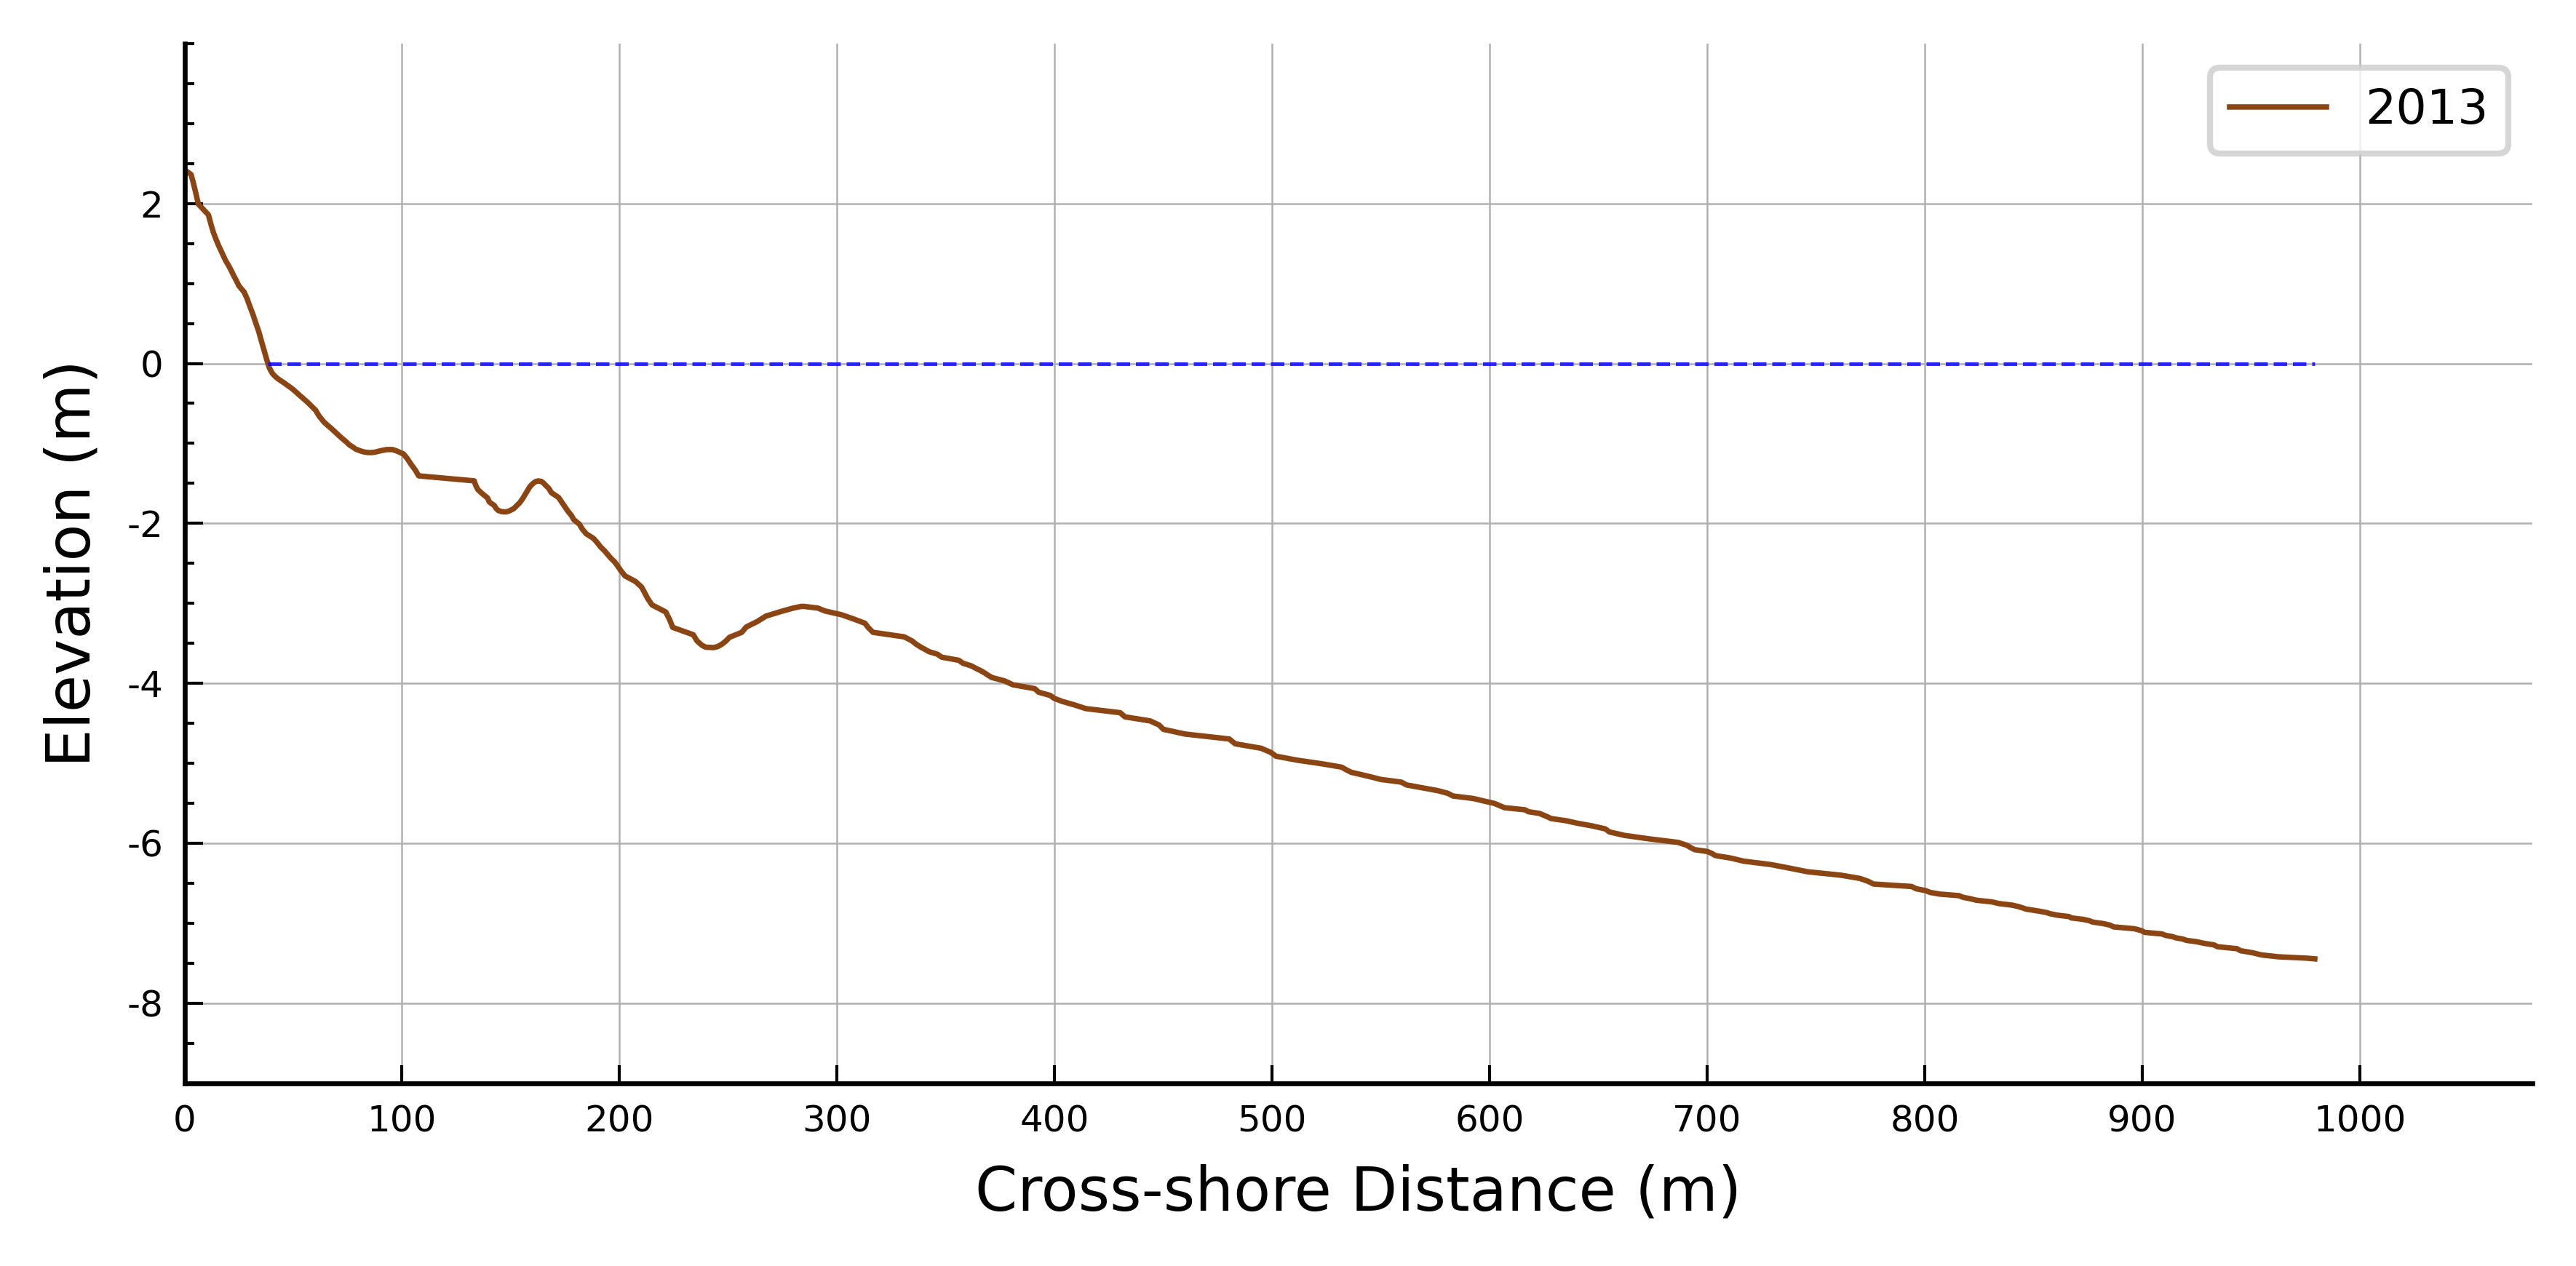

Plot saved as Dastak_profile_2013_plot.png


In [4]:
# Read the data from the Excel file
original_profile_data = pd.read_excel(excel_file, sheet_name=sheet_name)

# Check if required columns exist
if 'x' not in original_profile_data.columns or 'z' not in original_profile_data.columns:
    raise ValueError("Columns 'x' and 'z' are required in the dataset.")

# Extract the X and Z columns
x_column = original_profile_data['x']
z_column = original_profile_data['z']

# Define the smoothing sigma and horizontal end limit
sigma = 2
# Note: hor_end is no longer needed since we'll use the max x value.
# hor_end = 1500  # Adjust the cross-shore distance limit

# Define the colors
profile_color = '#8B4513'  # Brown color for the profile
water_level_color = 'blue'  # Blue color for the water level

# Smooth the profile data (Z values)
smoothed_z = gaussian_filter1d(z_column.values, sigma=sigma)

# Use the profile year entered by the user
year = str(profile_year)  # Use the profile year input earlier

# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)

# Plot the profile for the specified date with brown color
ax.plot(x_column, smoothed_z, '-', linewidth=0.9, c=profile_color, label=f"{year}")

# Calculate the water level (which is the intersection at Z = 0)
water_level = 0  # The water level is the 0-elevation line

# Plot the water level line starting after the conjunction point
profile_x = x_column
profile_z = smoothed_z

# Find the index where the profile data crosses the water level
crossing_indices = np.where(np.diff(np.sign(profile_z - water_level)))[0]

if len(crossing_indices) > 0:
    # Interpolate to find the exact x position where the profile crosses the water level
    idx = crossing_indices[0]  # Take the first crossing point
    x1, x2 = profile_x[idx], profile_x[idx + 1]
    z1, z2 = profile_z[idx], profile_z[idx + 1]
    
    # Linear interpolation to find the exact crossing point
    x_intersection = x1 + (water_level - z1) * (x2 - x1) / (z2 - z1)
    
    # Plot the water level line starting from the intersection
    ax.hlines(
        y=water_level,
        xmin=x_intersection, 
        xmax=max(x_column),  # CORRECTED: Dynamically set the end to the max x value
        linestyle='--', alpha=0.8, linewidth=0.6, color=water_level_color
    )
else:
    print("No intersection found between the profile and the water level.")

# Customize the plot
# Set the x-axis limit to 100 meters after the last x-value of the profile
ax.set_xlim(0, max(x_column) + 100)  # Add 100 meters beyond the maximum x-value

# Set y-axis limit based on the given range (from -9 to 4 as in previous code)
ax.set_ylim(-9, 4)

# Set labels and grid
ax.set_xlabel('Cross-shore Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.grid(lw=0.3)
ax.legend(frameon=True, loc='upper right', fontsize=8)

# Set major and minor ticks on y-axis (same as previous code)
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.set_yticks([2, 0, -2, -4, -6, -8])
ax.set_yticklabels(["2", "0", "-2", "-4", "-6", "-8"], fontsize=6)
ax.tick_params(axis='y', which='major', direction='in', length=3, width=0.5, left=True)
ax.tick_params(axis='y', which='minor', direction='in', length=1.5, width=0.5, left=True)

# Set major and minor ticks on x-axis (same as previous code)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='x', which='major', direction='in', length=3, width=0.5)
ax.tick_params(axis='x', which='minor', direction='in', length=3, width=0.7)

# Remove the top and right spines (same as previous code)
ax.spines[['right', 'top']].set_visible(False)

# Save and show the plot
output_filename = f'{sheet_name}_profile_{year}_plot.png'
plt.tight_layout()
plt.savefig(output_filename, dpi=1200, bbox_inches='tight')
plt.show()

print(f"Plot saved as {output_filename}")

In [53]:
# Function to calculate the Bruun Rule shoreline advancement
def calculate_bruun_rule(S, W, B, h):
    """
    This function calculates the shoreline advancement (R) based on the Bruun Rule.
    S: Water Level Fall (negative value)
    W: Active Zone Cross-shore Distance
    B: Berm Elevation (positive value)
    h: Closure Depth (negative value)
    
    Returns the shoreline advancement (R)
    """
    try:
        # Apply the Bruun Rule formula
        R = (-S * W) / (B + (-h))
        return R
    except ZeroDivisionError:
        print("Error: Division by zero encountered in Bruun Rule calculation.")
        return None

# Calculate Bruun Rule shoreline advancement (R)
if berm_x is not None and closure_x is not None:
    W = np.abs(berm_x - closure_x)  # Active zone cross-shore distance
    
    # Now calculate Bruun Rule shoreline advancement using previously stored variables
    R = calculate_bruun_rule(S, W, B, h)

    if R is not None:
        print(f"The Bruun Rule shoreline advancement (R) is: {R:.1f} meters.")
    else:
        print("Error in calculating shoreline advancement.")


The Bruun Rule shoreline advancement (R) is: 69.6 meters.


In [54]:
# Shift the profile data horizontally and vertically
if R is not None and berm_x is not None and closure_x is not None:
    # Shift the x-values (horizontal shift)
    shifted_x = x_column + R  # Shift the x values by the shoreline advancement

    # Shift the z-values (vertical shift)
    shifted_z = z_column + S  # Use S for the water level fall

    # Create a new DataFrame for the shifted profile
    shifted_profile = pd.DataFrame({
        'x': shifted_x,
        'z': shifted_z
    })

    # Name the new Excel file using the predicted year
    predicted_profile_filename = f"predicted_profile_{predicted_year}.xlsx"
    
    # Save the shifted profile data for the predicted year to the new Excel file
    shifted_profile.to_excel(predicted_profile_filename, index=False)

    print(f"Predicted profile for the year {predicted_year} saved as {predicted_profile_filename}")
else:
    print("Error: Missing values for shoreline advancement or profile data.")


Predicted profile for the year 2021 saved as predicted_profile_2021.xlsx


In [55]:
# Load the new Excel file (for the predicted year profile data)
predicted_profile_data = pd.read_excel(predicted_profile_filename)

# Extract x and z columns
x_column = predicted_profile_data['x'].values
z_column = predicted_profile_data['z'].values

# --- CORRECTED CODE ---
# Sort the data by x-values to prevent negative distance issues
sorted_indices = np.argsort(x_column)
x_column = x_column[sorted_indices]
z_column = z_column[sorted_indices]
# --- END OF CORRECTION ---

# Initialize lists to store the new x and z values after interpolation
new_x_values = [x_column[0]]
new_z_values = [z_column[0]]

# Loop through the data and check the distance between consecutive points
for i in range(1, len(x_column)):
    x1, z1 = x_column[i-1], z_column[i-1]
    x2, z2 = x_column[i], z_column[i]

    # --- CORRECTED CODE ---
    # Use the absolute distance for calculation
    distance = np.abs(x2 - x1)

    # If the distance between the points exceeds 2 meters, interpolate new points
    if distance > 2:
        # Calculate the number of new points needed
        num_new_points = int(np.floor(distance / 2))
    # --- END OF CORRECTION ---
        
        # Generate new x values between x1 and x2
        new_xs = np.linspace(x1, x2, num_new_points + 2)[1:-1]
        
        # Use linear interpolation to find the corresponding z values for the new x's
        new_zs = np.interp(new_xs, [x1, x2], [z1, z2])
        
        # Append the new x and z values
        new_x_values.extend(new_xs)
        new_z_values.extend(new_zs)
    
    # Always append the current x and z value
    new_x_values.append(x2)
    new_z_values.append(z2)

# Create a new DataFrame with the updated x and z values
updated_profile = pd.DataFrame({
    'x': new_x_values,
    'z': new_z_values
})

# Save the updated profile to a new Excel file
updated_predicted_profile_data = f"updated_predicted_profile_data_{predicted_year}.xlsx"
updated_profile.to_excel(updated_predicted_profile_data, index=False)

print(f"Updated profile with interpolated points saved as {updated_predicted_profile_data}")

Updated profile with interpolated points saved as updated_predicted_profile_data_2021.xlsx


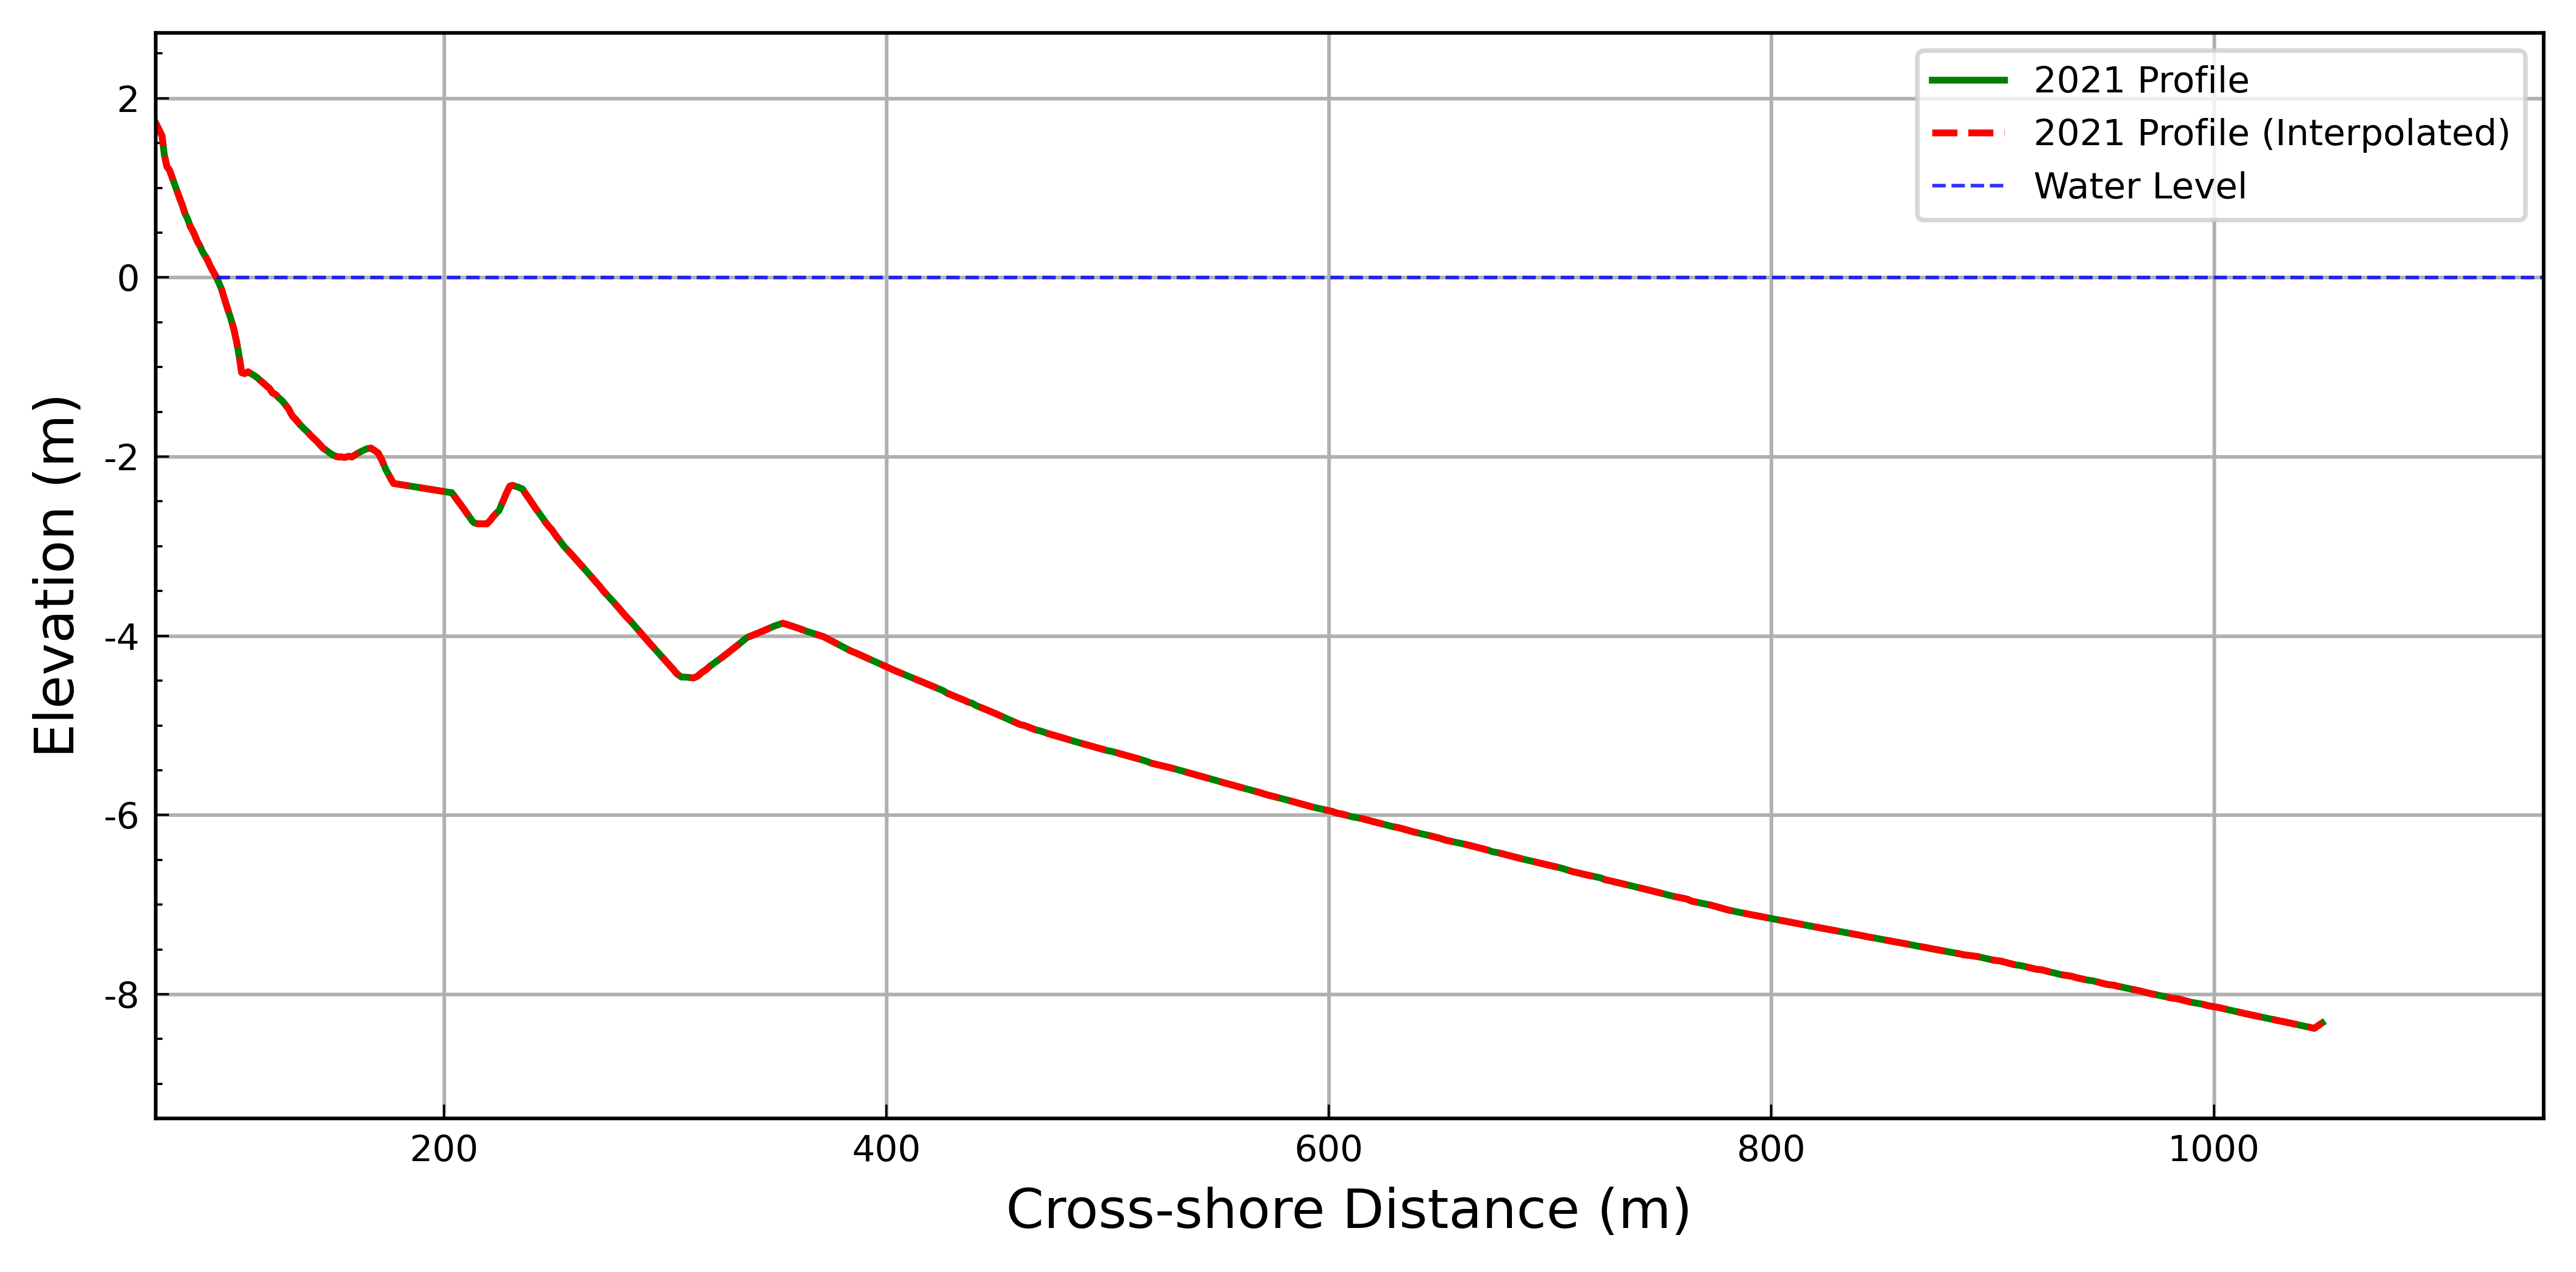

Plot saved as comparison_profile_2021.png


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import os.path
from scipy.ndimage import gaussian_filter1d

# Load the predicted profile (original) and updated profile (with interpolated points)
predicted_profile_data = pd.read_excel(predicted_profile_filename)
updated_profile_data = pd.read_excel(updated_predicted_profile_data)

# Extract the x and z values for both profiles
x_predicted = predicted_profile_data['x'].values
z_predicted = predicted_profile_data['z'].values

x_updated = updated_profile_data['x'].values
z_updated = updated_profile_data['z'].values

# Smooth the predicted profile data to find the intersection point
smoothed_z_predicted = gaussian_filter1d(z_predicted, sigma=2)

# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=600)

# Plot the predicted profile (in green as requested) with the year in the label
ax.plot(x_predicted, z_predicted, label=f'{predicted_year} Profile', color='green', linewidth=1.5)

# Plot the updated profile (with interpolated points) with the year in the label
ax.plot(x_updated, z_updated, label=f'{predicted_year} Profile (Interpolated)', color='red', linewidth=1.5, linestyle='--')

# --- Add Water Level Line ---
water_level = 0
crossing_indices = np.where(np.diff(np.sign(smoothed_z_predicted - water_level)))[0]

if len(crossing_indices) > 0:
    idx = crossing_indices[0]
    x1, x2 = x_predicted[idx], x_predicted[idx + 1]
    z1, z2 = smoothed_z_predicted[idx], smoothed_z_predicted[idx + 1]
    
    # Linear interpolation to find the exact crossing point on the predicted profile
    x_intersection = x1 + (water_level - z1) * (x2 - x1) / (z2 - z1)
    
    # Plot the water level line starting from the intersection of the predicted profile
    ax.hlines(
        y=water_level,
        xmin=x_intersection,
        xmax=max(x_predicted) + 100, # Extend to the end of the plot x-limit
        linestyle='--',
        alpha=0.8,
        linewidth=0.8,
        color='blue', # Water level line is blue as requested
        label='Water Level'
    )
else:
    print("No intersection found for the predicted profile at the water level (Z=0).")
# --- End of Water Level Line Code ---

# Customize the plot
ax.set_xlabel('Cross-shore Distance (m)', fontsize=12)
ax.set_ylabel('Elevation (m)', fontsize=12)
# Updated legend position to 'upper right' and smaller font size
ax.legend(loc='upper right', fontsize=8)
ax.grid(True)

# Set x and y limits based on the data
ax.set_xlim(min(x_predicted), max(x_updated) + 100)
ax.set_ylim(min(z_predicted) - 1, max(z_updated) + 1)

# Set major and minor ticks on y-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.set_yticks([2, 0, -2, -4, -6, -8])
ax.set_yticklabels(["2", "0", "-2", "-4", "-6", "-8"], fontsize=8)
ax.tick_params(axis='y', which='major', direction='in', length=3, width=0.5, left=True)
ax.tick_params(axis='y', which='minor', direction='in', length=1.5, width=0.5, left=True)

# Set major and minor ticks on x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='x', which='major', direction='in', length=3, width=0.5)
ax.tick_params(axis='x', which='minor', direction='in', length=3, width=0.7)

# Save the plot as an image file
output_plot_filename = f"comparison_profile_{predicted_year}.png"
plt.tight_layout()
plt.savefig(output_plot_filename, dpi=1200)
plt.show()

print(f"Plot saved as {output_plot_filename}")

End point of closure depth intersection at X: 539.47 m


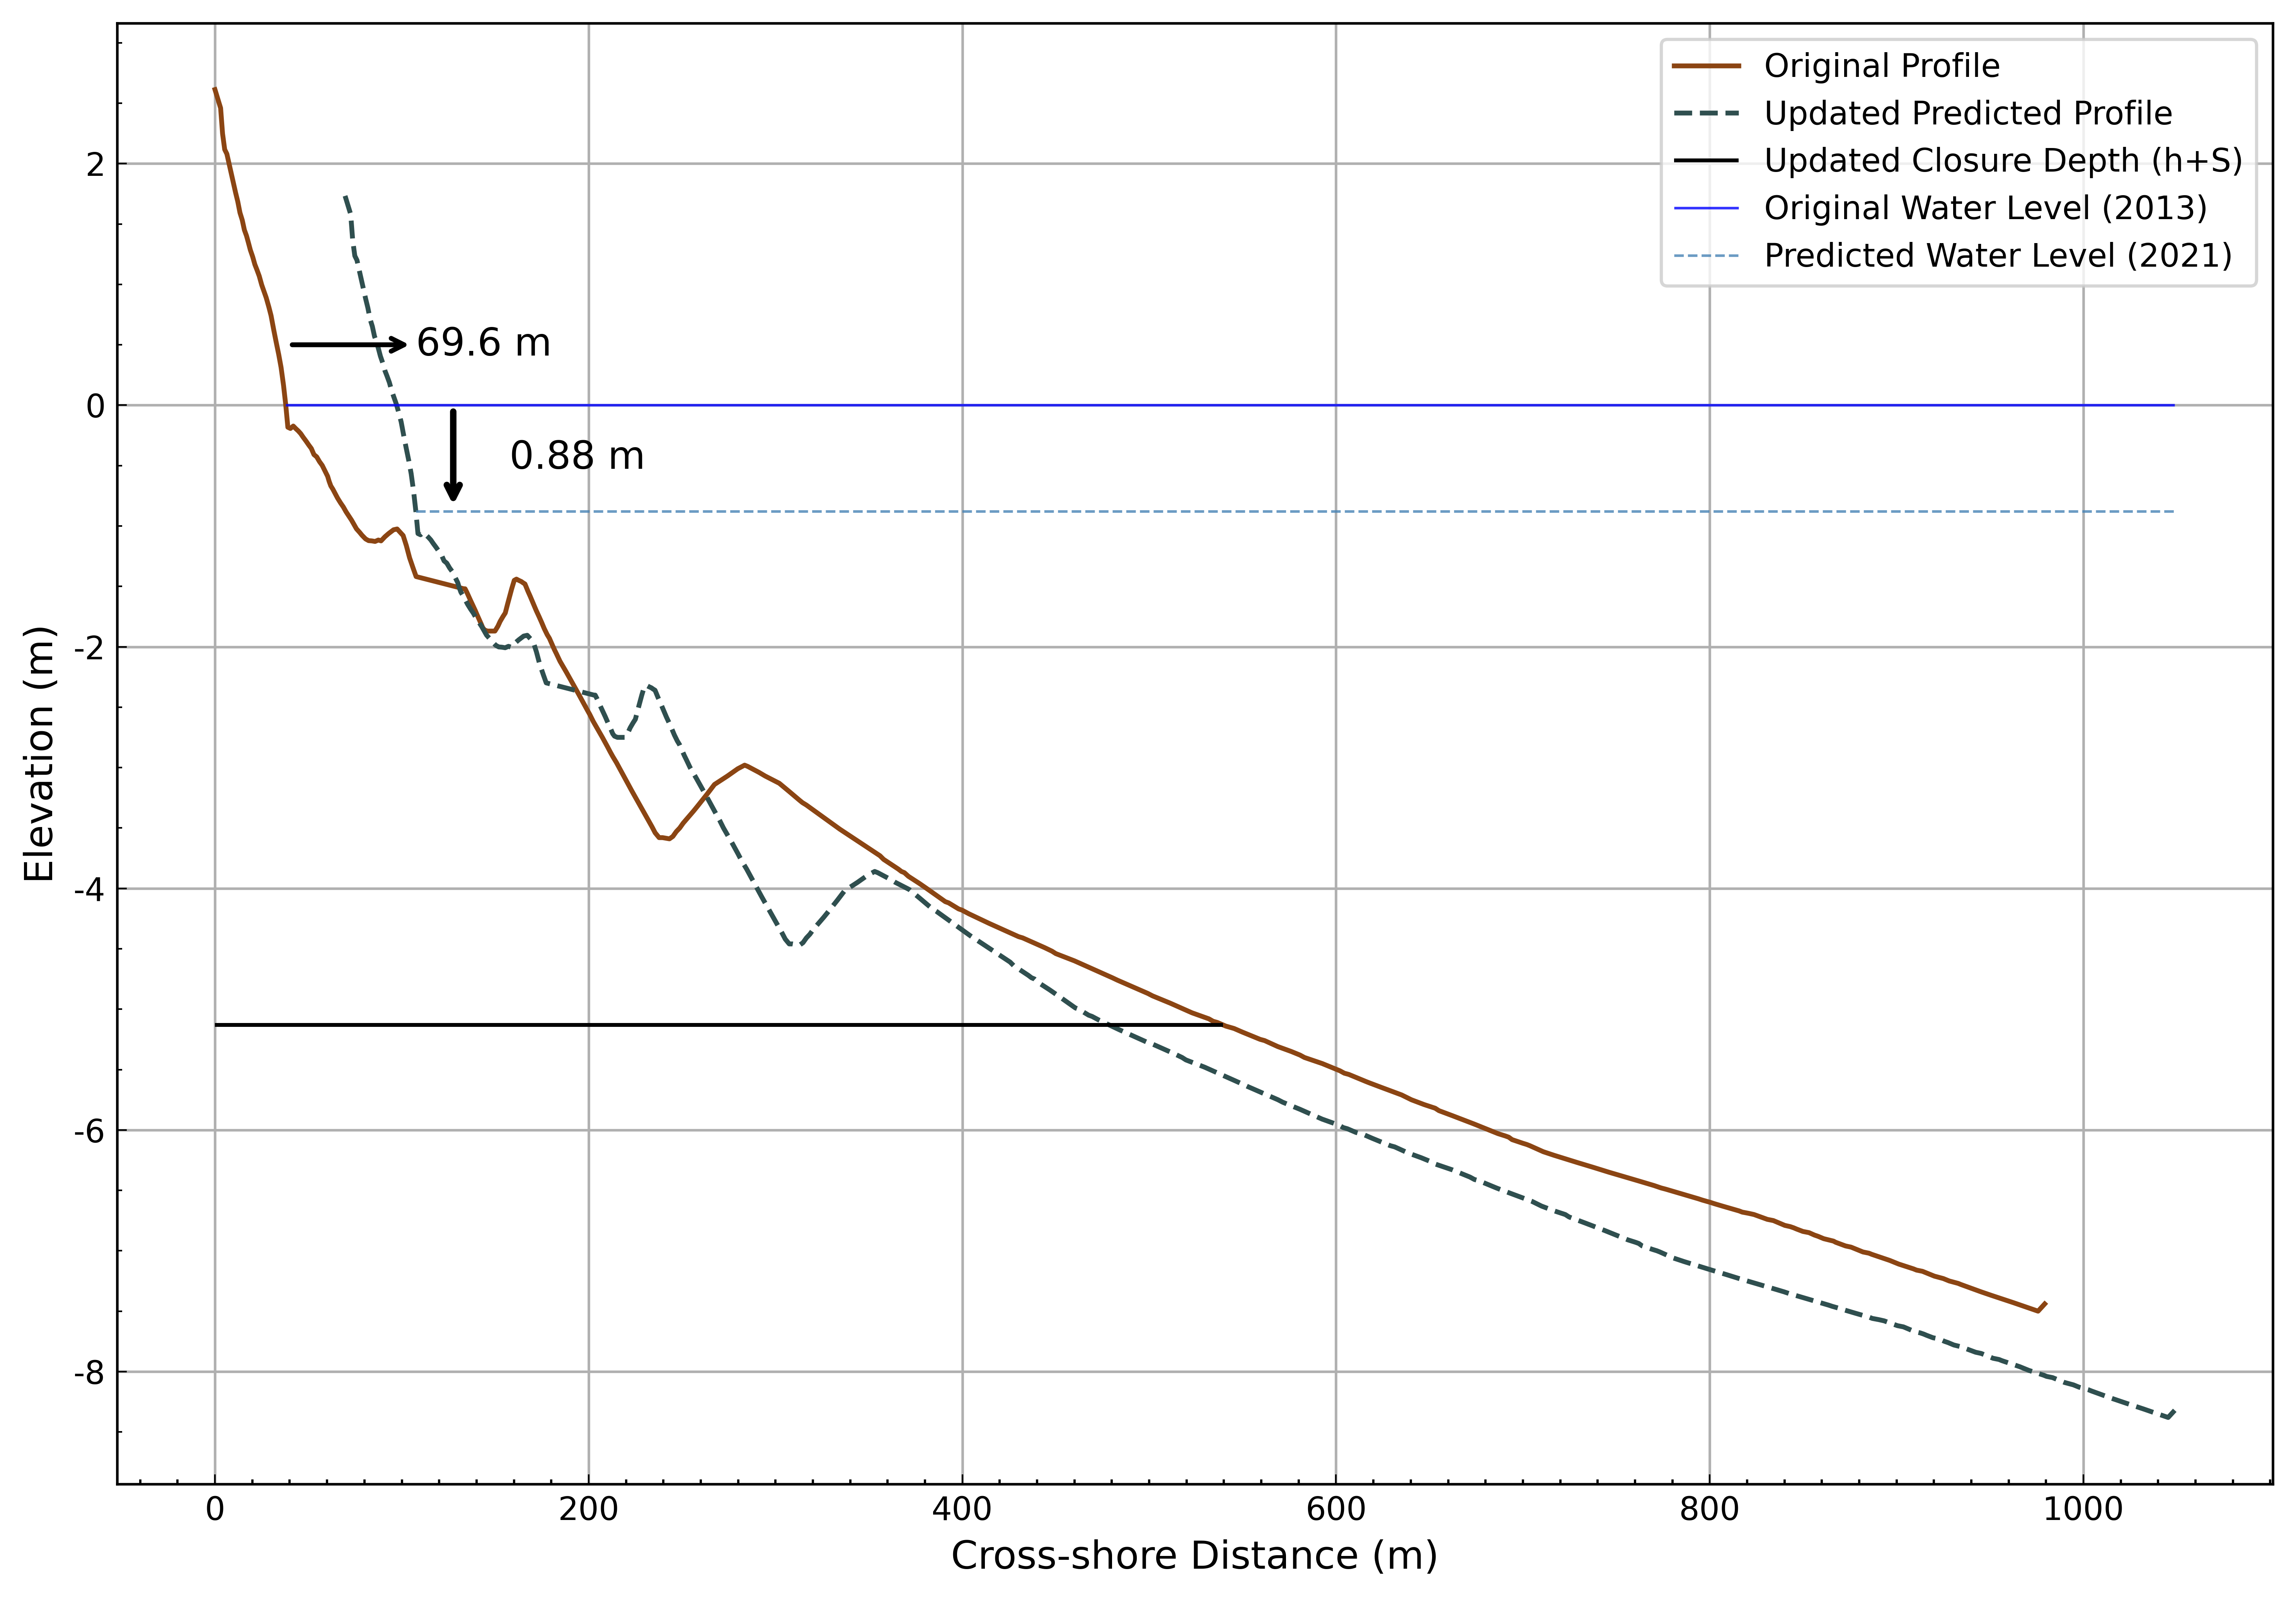

Plot saved as original_vs_updated_profile_2021.png


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import os.path

# Load the updated predicted profile and original profile using the given filenames
updated_profile_data = pd.read_excel(updated_predicted_profile_data)  # Load the updated profile with interpolated points
original_profile_data = pd.read_excel(excel_file, sheet_name=sheet_name)  # Load the original profile

# Extract x and z values for both profiles
x_original = original_profile_data['x'].values
z_original = original_profile_data['z'].values

x_updated = updated_profile_data['x'].values
z_updated = updated_profile_data['z'].values

# Calculate updated closure depth with water level fall
closure_depth_with_fall = h + S  # Calculate the updated closure depth (h + S)

# Find the intersection point between the closure depth and the original profile
closure_depth_intersection_idx = np.where(np.diff(np.sign(z_original - closure_depth_with_fall)))[0]

if len(closure_depth_intersection_idx) > 0:
    # Interpolate to find the exact x position where the closure depth intersects the profile
    idx = closure_depth_intersection_idx[0]
    x1, x2 = x_original[idx], x_original[idx + 1]
    z1, z2 = z_original[idx], z_original[idx + 1]
    
    # Linear interpolation to find the exact crossing point
    End_point = x1 + (closure_depth_with_fall - z1) * (x2 - x1) / (z2 - z1)
    print(f"End point of closure depth intersection at X: {End_point:.2f} m")
else:
    print("No intersection found for closure depth.")
    End_point = float('nan')

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 7), dpi=600)

# Plot the original profile with specified color
ax.plot(x_original, z_original, label='Original Profile', color='#8B4513', linewidth=1.5)

# Plot the updated predicted profile with specified color
ax.plot(x_updated, z_updated, label='Updated Predicted Profile', color='#2F4F4F', linewidth=1.5, linestyle='--')

# Plot the updated closure depth line
ax.hlines(closure_depth_with_fall, min(x_original), End_point, color='black', linewidth=1.2, label=f'Updated Closure Depth (h+S)')

# --- Add Water Level Lines and Arrows ---
# Find the intersection point of the original profile and the water level
water_level = 0
crossing_indices_original = np.where(np.diff(np.sign(z_original - water_level)))[0]

if len(crossing_indices_original) > 0:
    idx_orig = crossing_indices_original[0]
    x1_orig, x2_orig = x_original[idx_orig], x_original[idx_orig + 1]
    z1_orig, z2_orig = z_original[idx_orig], z_original[idx_orig + 1]
    
    # Linear interpolation to find the exact crossing point
    x_intersection_orig = x1_orig + (water_level - z1_orig) * (x2_orig - x1_orig) / (z2_orig - z1_orig)
    
    # Plot the original water level line
    ax.hlines(
        y=water_level,
        xmin=x_intersection_orig, xmax=max(x_updated),
        linestyle='-', alpha=0.8, linewidth=0.8, color='blue', label=f'Original Water Level ({profile_year})'
    )
    
    # Plot the predicted water level
    ax.hlines(
        y=water_level + S,
        xmin=x_intersection_orig + R, xmax=max(x_updated),
        linestyle='--', alpha=0.8, linewidth=0.8, color='#4682B4', label=f'Predicted Water Level ({predicted_year})'
    )

    # Add downward arrow for water level fall
    arrow_x_pos = x_intersection_orig + R + 20
    arrow_y_start = water_level
    arrow_y_end = arrow_y_start + S
    
    ax.annotate(
        '',
        xy=(arrow_x_pos, arrow_y_end),
        xytext=(arrow_x_pos, arrow_y_start),
        arrowprops=dict(arrowstyle='->', color='black', lw=2)
    )

    # Label for vertical arrow (water level fall)
    ax.text(
        arrow_x_pos + 30,
        (arrow_y_start + arrow_y_end) / 2,
        f'{abs(S):.2f} m',
        va='center',
        fontsize=12,
        color='black'
    )
    
    # Add horizontal arrow for shoreline advance
    arrow_x_start = x_intersection_orig
    arrow_x_end = arrow_x_start + R
    arrow_y = 0.5
    
    ax.annotate(
        '',
        xy=(arrow_x_end, arrow_y),
        xytext=(arrow_x_start, arrow_y),
        arrowprops=dict(arrowstyle='->', color='black', lw=1.5)
    )

    # Label for horizontal arrow (shoreline advance)
    ax.text(
        arrow_x_end,
        arrow_y,
        f'{abs(R):.1f} m',
        ha='left',
        va='center',
        fontsize=12,
        color='black'
    )
else:
    print("No intersection found for original water level.")
# --- End of Water Level Lines and Arrows Code ---

# Customize the plot
ax.set_xlabel('Cross-shore Distance (m)', fontsize=12)
ax.set_ylabel('Elevation (m)', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True)

# Set major and minor ticks on y-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.set_yticks([2, 0, -2, -4, -6, -8])
ax.set_yticklabels(["2", "0", "-2", "-4", "-6", "-8"], fontsize=10)
ax.tick_params(axis='y', which='major', direction='in', length=3, width=0.5, left=True, labelsize=10)
ax.tick_params(axis='y', which='minor', direction='in', length=1.5, width=0.5, left=True)

# Set major and minor ticks on x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='x', which='major', direction='in', length=3, width=0.5)
ax.tick_params(axis='x', which='minor', direction='in', length=1.5, width=0.7)

# Save the plot as an image file
output_plot_filename = f"original_vs_updated_profile_{predicted_year}.png"
plt.tight_layout()
plt.savefig(output_plot_filename, dpi=1200)
plt.show()

print(f"Plot saved as {output_plot_filename}")

In [58]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Define the updated original filename
updated_original_filename = "updated_original_profile.xlsx"

# Assuming you already have the End point from the previous code

# Extract x and z values for the original and updated predicted profiles
x_original = original_profile_data['x'].values
z_original = original_profile_data['z'].values

x_updated = updated_profile_data['x'].values
z_updated = updated_profile_data['z'].values

# Define the range of x values to consider (from R to the End point)
start_x = R
end_x = End_point  # This is the End point from the previous code

# Filter the updated predicted profile points that are within the range [R, End point]
updated_in_range = x_updated[(x_updated >= start_x) & (x_updated <= end_x)]

# Create a function to interpolate the original profile
interp_func = interp1d(x_original, z_original, kind='linear', fill_value='extrapolate')

# For each x in the updated predicted profile, interpolate the corresponding z from the original profile
interpolated_z_values = interp_func(updated_in_range)

# Add the corresponding x and interpolated z values to the original profile
new_points = pd.DataFrame({
    'x': updated_in_range,
    'z': interpolated_z_values
})

# Append the new points to the original profile dataframe
original_profile_data = pd.concat([original_profile_data, new_points], ignore_index=True)

# Sort the data by x values to maintain the order
original_profile_data = original_profile_data.sort_values(by='x').reset_index(drop=True)

# Save the updated original profile with new points
original_profile_data.to_excel(updated_original_filename, index=False)

# Print confirmation
print(f"Updated original profile saved as {updated_original_filename}.")


Updated original profile saved as updated_original_profile.xlsx.


In [59]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Load the updated original profile and updated predicted profile
updated_original_profile_data = pd.read_excel("updated_original_profile.xlsx")  # Updated original profile
updated_predicted_profile_data = pd.read_excel(f"updated_predicted_profile_data_{predicted_year}.xlsx")  # Updated predicted profile

# Interpolate the updated original profile to the x values of the updated predicted profile
interp_func_original = interp1d(updated_original_profile_data['x'], updated_original_profile_data['z'], kind='linear', fill_value='extrapolate')
original_z_interpolated = interp_func_original(updated_predicted_profile_data['x'])

# Calculate the difference between the two profiles at the common x points
z_diff = updated_predicted_profile_data['z'] - original_z_interpolated

# Find where the sign of the difference changes, indicating an intersection
sign_change_indices = np.where(np.diff(np.sign(z_diff)))[0]

# Extract the x-values where the intersection happens
intersection_x_values = updated_predicted_profile_data['x'][sign_change_indices]

# Interpolate to find the exact z-values of the intersection points
intersection_z_values = original_z_interpolated[sign_change_indices]

# Create a DataFrame to store the intersection points
intersection_points = pd.DataFrame({
    'x': intersection_x_values,
    'z': intersection_z_values
})

# Print the intersection points
print(f"Intersection Points:\n{intersection_points}")

# Optional: Save the intersection points to a new Excel file
intersection_points_filename = f"intersection_points_{predicted_year}.xlsx"
intersection_points.to_excel(intersection_points_filename, index=False)

# Print confirmation of the file save
print(f"Intersection points saved as {intersection_points_filename}.")


Intersection Points:
              x         z
46   129.938346 -1.507147
88   192.994578 -2.346826
139  262.737803 -3.232509
Intersection points saved as intersection_points_2021.xlsx.


In [60]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Load the updated original profile and updated predicted profile
updated_original_profile_data = pd.read_excel("updated_original_profile.xlsx")  # Updated original profile
updated_predicted_profile_data = pd.read_excel(f"updated_predicted_profile_data_{predicted_year}.xlsx")  # Updated predicted profile

# Interpolate the updated original profile to the x values of the updated predicted profile
interp_func_original = interp1d(updated_original_profile_data['x'], updated_original_profile_data['z'], kind='linear', fill_value='extrapolate')
original_z_interpolated = interp_func_original(updated_predicted_profile_data['x'])

# Calculate the difference between the two profiles at the common x points
z_diff = updated_predicted_profile_data['z'] - original_z_interpolated

# Find where the sign of the difference changes, indicating an intersection
sign_change_indices = np.where(np.diff(np.sign(z_diff)))[0]

# Extract the x-values where the intersection happens
intersection_x_values = updated_predicted_profile_data['x'][sign_change_indices]

# Interpolate to find the exact z-values of the intersection points
intersection_z_values = original_z_interpolated[sign_change_indices]

# Create a DataFrame to store the intersection points
intersection_points = pd.DataFrame({
    'x': intersection_x_values,
    'z': intersection_z_values
})

# Print the intersection points
print(f"Intersection Points:\n{intersection_points}")

# First important point: R and the corresponding z from updated predicted profile
first_point = {
    'x': R,
    'z': updated_predicted_profile_data.loc[updated_predicted_profile_data['x'] == R, 'z'].values[0]
}

# End point: The x-value and z-value where x = End_point, and z = h + S
end_point = {
    'x': End_point,
    'z': h + S
}

# Combine the important points and intersection points into one DataFrame
important_points = pd.DataFrame([first_point, end_point])

# Combine important points with intersection points
all_points = pd.concat([important_points, intersection_points], ignore_index=True)

# Sort the points by x (ascending order)
all_points_sorted = all_points.sort_values(by='x').reset_index(drop=True)

# Print all the points in order of x
print(f"\nAll Important Points and Intersection Points (sorted by x):\n{all_points_sorted}")


Intersection Points:
              x         z
46   129.938346 -1.507147
88   192.994578 -2.346826
139  262.737803 -3.232509

All Important Points and Intersection Points (sorted by x):
            x         z
0   69.629620  1.732500
1  129.938346 -1.507147
2  192.994578 -2.346826
3  262.737803 -3.232509
4  539.465211 -5.130000


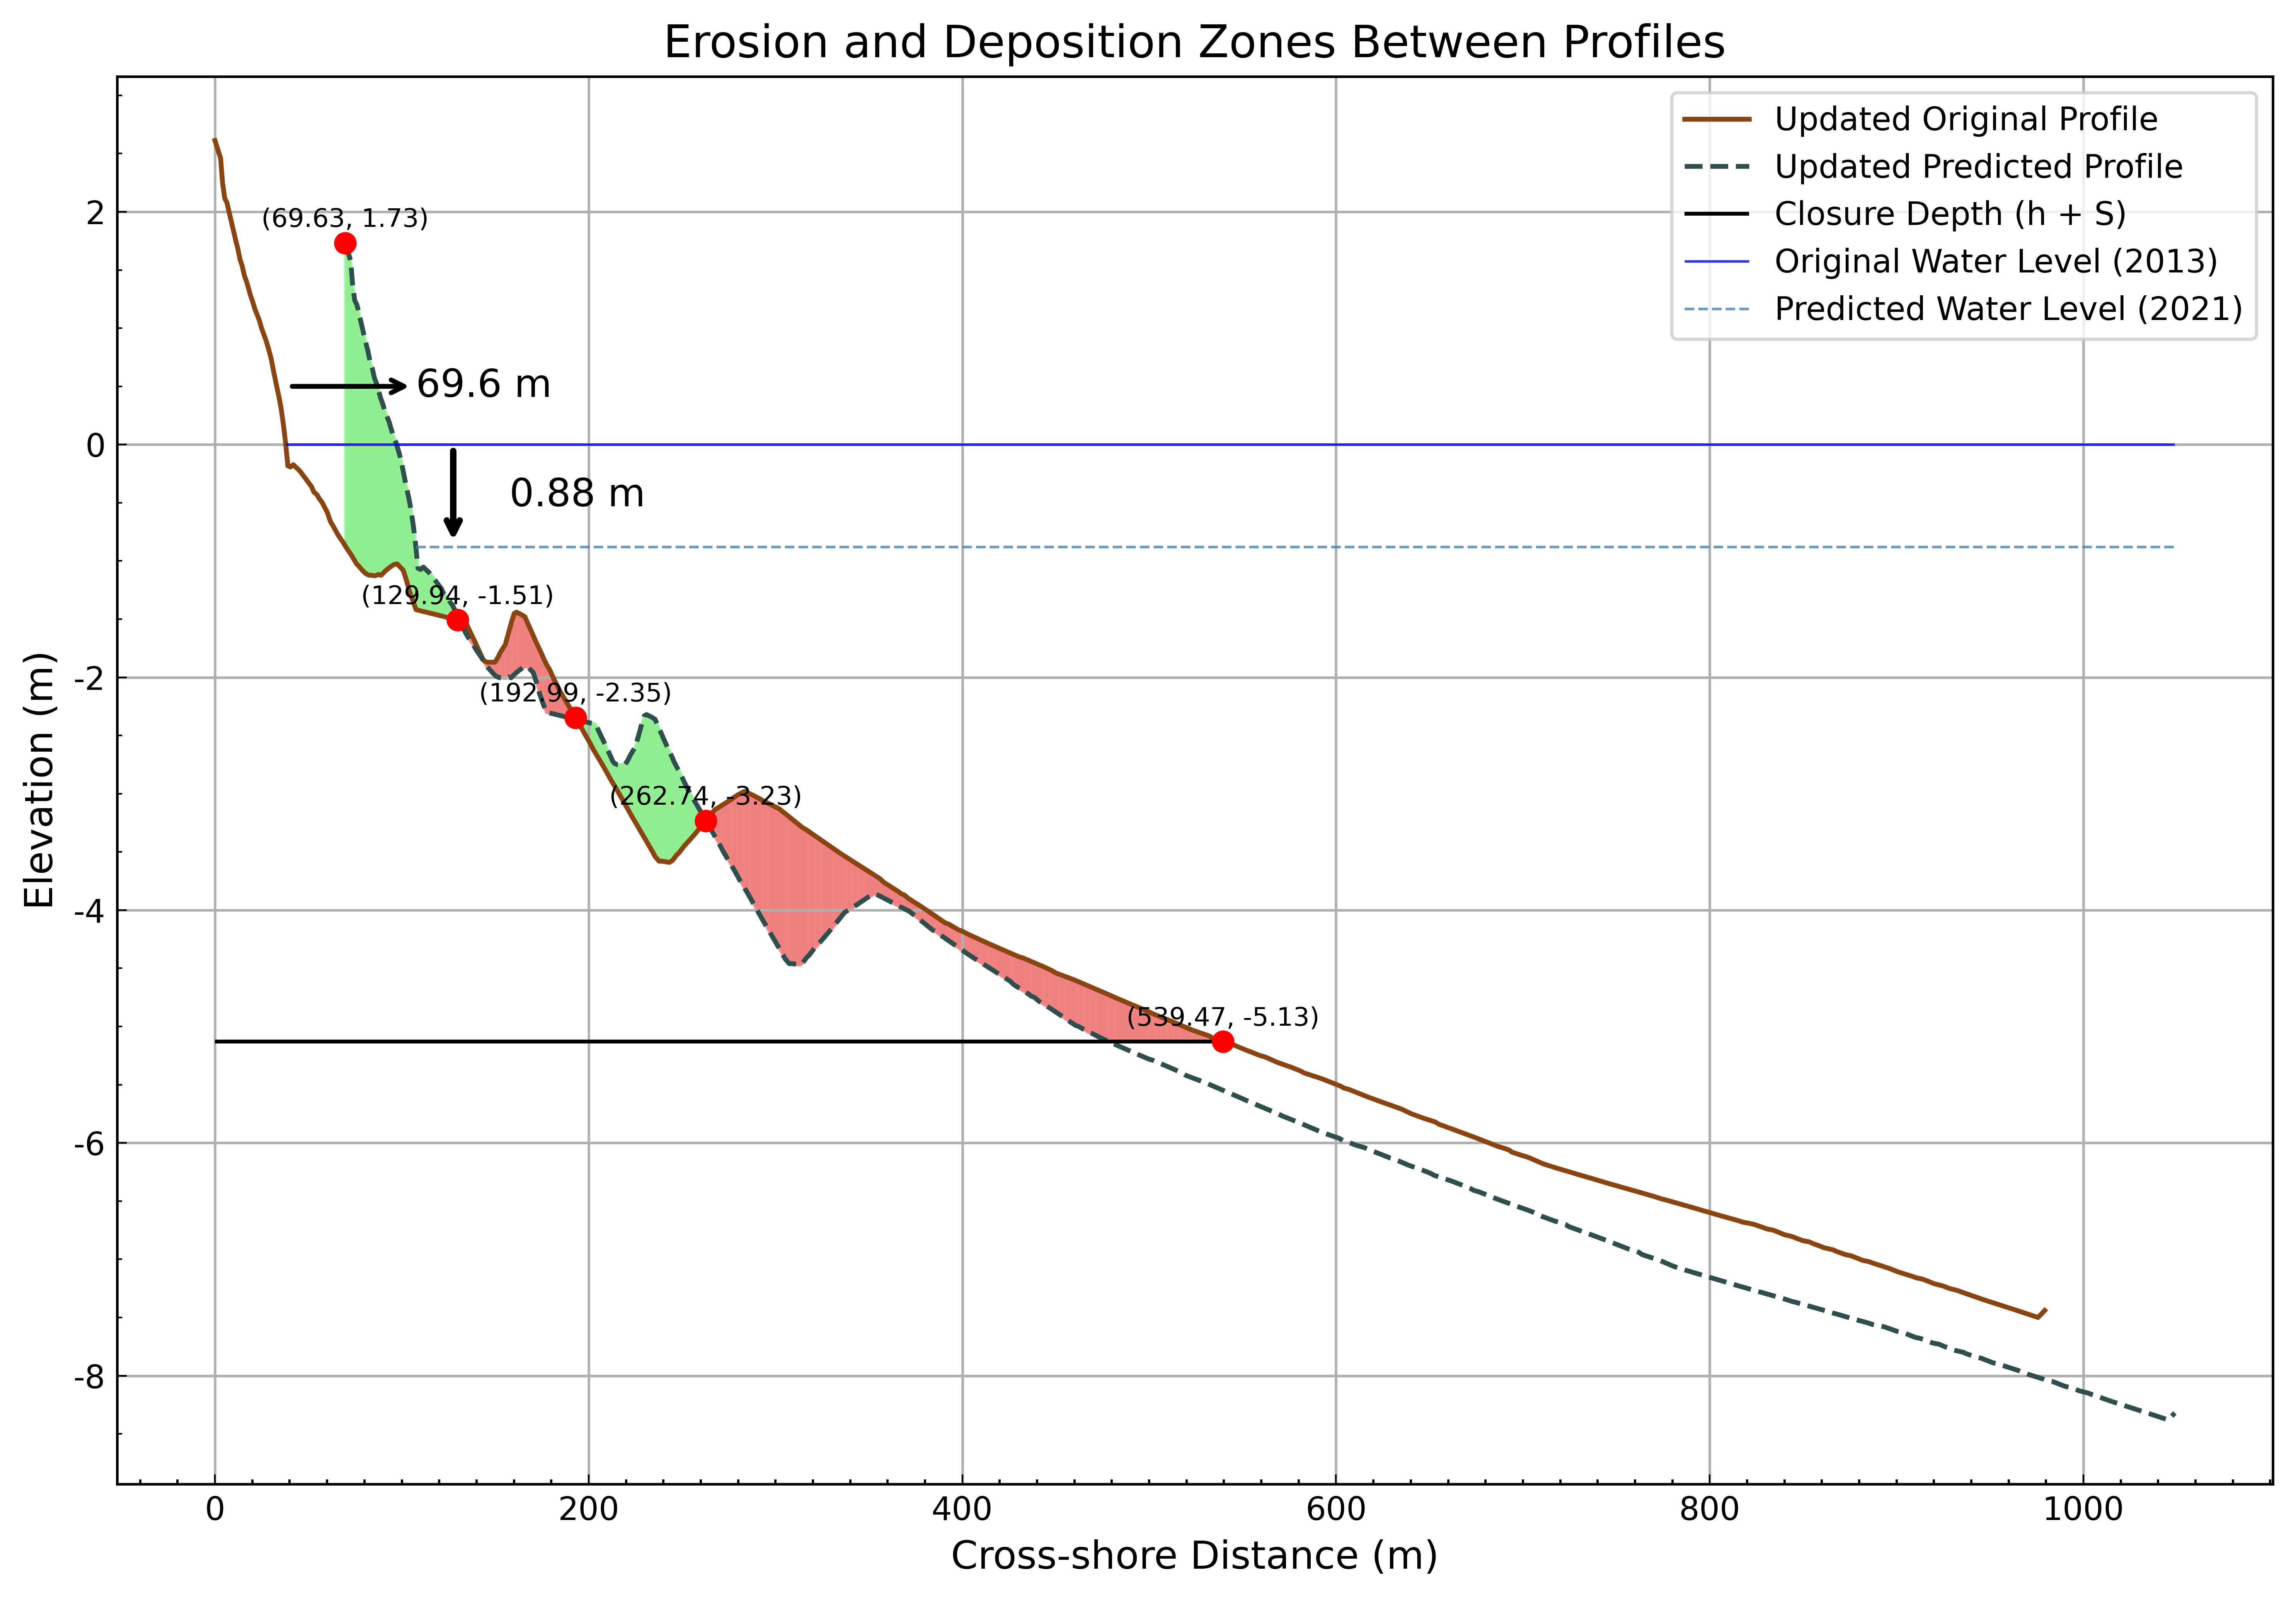

Plot saved as 'erosion_deposition_with_points.png'.


In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import os
import os.path
from scipy.ndimage import gaussian_filter1d

# Assuming necessary data (updated_original_profile_data, updated_predicted_profile_data) are available
# Let's assume `R`, `End_point`, `h`, and `S` are defined.

# Calculate closure depth with water level fall
closure_depth_with_fall = h + S  # Assuming h and S are already defined

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 7), dpi=600)

# Plot the updated original profile
ax.plot(updated_original_profile_data['x'], updated_original_profile_data['z'], label='Updated Original Profile', color='#8B4513', linewidth=1.5)

# Plot the updated predicted profile
ax.plot(updated_predicted_profile_data['x'], updated_predicted_profile_data['z'], label='Updated Predicted Profile', color='#2F4F4F', linewidth=1.5, linestyle='--')

# Define the range of x from R to End_point (the last x value from the data)
x_range = np.linspace(R, End_point, num=1000)  # Generate intermediate x-values between R and End_point

# Interpolate z-values for the updated original and predicted profiles at these x values
original_interp = np.interp(x_range, updated_original_profile_data['x'], updated_original_profile_data['z'])
predicted_interp = np.interp(x_range, updated_predicted_profile_data['x'], updated_predicted_profile_data['z'])

# Highlight the area between the two profile lines, considering the closure depth condition
for i in range(len(x_range) - 1):
    x1, x2 = x_range[i], x_range[i + 1]
    z1_original, z2_original = original_interp[i], original_interp[i + 1]
    z1_predicted, z2_predicted = predicted_interp[i], predicted_interp[i + 1]

    # Clip the z-values to be above the closure depth
    z1_original = max(z1_original, closure_depth_with_fall)
    z2_original = max(z2_original, closure_depth_with_fall)
    z1_predicted = max(z1_predicted, closure_depth_with_fall)
    z2_predicted = max(z2_predicted, closure_depth_with_fall)

    # Highlight the area between the lines where the original profile is higher (erosion)
    if z1_original > z1_predicted:
        ax.fill_between([x1, x2], [z1_original, z2_original], [z1_predicted, z2_predicted], color='lightcoral', alpha=0.5)

    # Highlight the area between the lines where the predicted profile is higher (deposition)
    elif z1_predicted > z1_original:
        ax.fill_between([x1, x2], [z1_original, z2_original], [z1_predicted, z2_predicted], color='lightgreen', alpha=0.5)

# Plot the closure depth line (black) from x=0 to End_point
ax.hlines(closure_depth_with_fall, 0, End_point, color='black', linewidth=1.2, label=f'Closure Depth (h + S)')

# --- Water Level Lines and Arrows ---
# Find the intersection point of the original profile and the water level
water_level = 0
crossing_indices_original = np.where(np.diff(np.sign(original_profile_data['z'].values - water_level)))[0]

if len(crossing_indices_original) > 0:
    idx_orig = crossing_indices_original[0]
    x1_orig, x2_orig = original_profile_data['x'].values[idx_orig], original_profile_data['x'].values[idx_orig + 1]
    z1_orig, z2_orig = original_profile_data['z'].values[idx_orig], original_profile_data['z'].values[idx_orig + 1]
    
    x_intersection_orig = x1_orig + (water_level - z1_orig) * (x2_orig - x1_orig) / (z2_orig - z1_orig)
    
    ax.hlines(y=water_level, xmin=x_intersection_orig, xmax=max(updated_profile_data['x'].values), linestyle='-', alpha=0.8, linewidth=0.8, color='blue', label=f'Original Water Level ({profile_year})')
    
    ax.hlines(y=water_level + S, xmin=x_intersection_orig + R, xmax=max(updated_profile_data['x'].values), linestyle='--', alpha=0.8, linewidth=0.8, color='#4682B4', label=f'Predicted Water Level ({predicted_year})')

    # Add downward arrow for water level fall
    arrow_x_pos = x_intersection_orig + R + 20
    arrow_y_start = water_level
    arrow_y_end = arrow_y_start + S
    
    ax.annotate('', xy=(arrow_x_pos, arrow_y_end), xytext=(arrow_x_pos, arrow_y_start), arrowprops=dict(arrowstyle='->', color='black', lw=2))

    # Label for vertical arrow
    ax.text(arrow_x_pos + 30, (arrow_y_start + arrow_y_end) / 2, f'{abs(S):.2f} m', va='center', fontsize=12, color='black')
    
    # Add horizontal arrow for shoreline advance
    arrow_x_start = x_intersection_orig
    arrow_x_end = arrow_x_start + R
    arrow_y = 0.5
    
    ax.annotate('', xy=(arrow_x_end, arrow_y), xytext=(arrow_x_start, arrow_y), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    # Label for horizontal arrow
    ax.text(arrow_x_end, arrow_y, f'{abs(R):.1f} m', ha='left', va='center', fontsize=12, color='black')
else:
    print("No intersection found for original water level.")
# --- End of Water Level Lines and Arrows Code ---

# --- Restored Plotting of Important Points ---
# Note: The `all_points_sorted` variable needs to be defined in your script.
# Example: all_points_sorted = pd.DataFrame({'x': [some_x_val], 'z': [some_z_val]})
important_points = all_points_sorted.copy()
ax.scatter(important_points['x'], important_points['z'], color='red', zorder=5)
for idx, row in important_points.iterrows():
    ax.annotate(f"({row['x']:.2f}, {row['z']:.2f})", (row['x'], row['z']), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
# --- End of Restored Code ---

# Customize the plot
ax.set_xlabel('Cross-shore Distance (m)', fontsize=12)
ax.set_ylabel('Elevation (m)', fontsize=12)
ax.set_title('Erosion and Deposition Zones Between Profiles', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True)

# Set major and minor ticks on y-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.set_yticks([2, 0, -2, -4, -6, -8])
ax.set_yticklabels(["2", "0", "-2", "-4", "-6", "-8"], fontsize=10)
ax.tick_params(axis='y', which='major', direction='in', length=3, width=0.5, left=True, labelsize=10)
ax.tick_params(axis='y', which='minor', direction='in', length=1.5, width=0.5, left=True)

# Set major and minor ticks on x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='x', which='major', direction='in', length=3, width=0.5)
ax.tick_params(axis='x', which='minor', direction='in', length=1.5, width=0.7)

# Save the plot as an image file
plt.tight_layout()
plt.savefig("erosion_deposition_with_points.png", dpi=1200)
plt.show()

# Print confirmation message
print("Plot saved as 'erosion_deposition_with_points.png'.")

In [62]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


# Load the updated original and predicted profiles
updated_original_profile_data = pd.read_excel("updated_original_profile.xlsx")
updated_predicted_profile_data = pd.read_excel(f"updated_predicted_profile_data_{predicted_year}.xlsx")

# --- 2. Recalculate and sort the important points ---
interp_func_original = interp1d(updated_original_profile_data['x'], updated_original_profile_data['z'], kind='linear', fill_value='extrapolate')
original_z_interpolated = interp_func_original(updated_predicted_profile_data['x'])

z_diff = updated_predicted_profile_data['z'] - original_z_interpolated
sign_change_indices = np.where(np.diff(np.sign(z_diff)))[0]

intersection_x_values = updated_predicted_profile_data['x'][sign_change_indices]
intersection_z_values = original_z_interpolated[sign_change_indices]

intersection_points = pd.DataFrame({
    'x': intersection_x_values,
    'z': intersection_z_values
})

# First important point (at shoreline advancement)
first_point_z_predicted = updated_predicted_profile_data.loc[updated_predicted_profile_data['x'].round(2) == round(R, 2), 'z']
first_point = {
    'x': R,
    'z': first_point_z_predicted.values[0] if len(first_point_z_predicted.values) > 0 else np.nan
}

# End point (at closure depth)
end_point = {
    'x': End_point,
    'z': h + S
}

# Combine and sort all important points
all_points = pd.concat([pd.DataFrame([first_point, end_point]), intersection_points], ignore_index=True)
all_points_sorted = all_points.sort_values(by='x').reset_index(drop=True)

# --- 3. Calculate and store the area for each section ---
# Initialize dictionaries and counters for storing results
depositional_areas = {}
erosional_areas = {}
dep_count = 0
ero_count = 0

print("--- Calculating and Storing Area for Each Section ---")

# Iterate through each pair of consecutive important points
for i in range(len(all_points_sorted) - 1):
    start_point = all_points_sorted.iloc[i]
    end_point_area = all_points_sorted.iloc[i+1]

    # Filter data points that fall within the current section
    section_data = updated_predicted_profile_data[
        (updated_predicted_profile_data['x'] >= start_point['x']) &
        (updated_predicted_profile_data['x'] <= end_point_area['x'])
    ]

    if section_data.empty:
        print(f"Skipping section from {start_point['x']:.2f} to {end_point_area['x']:.2f} due to no data points.")
        continue

    # Get the interpolated original Z values for this section's X values
    original_z_section = interp_func_original(section_data['x'])

    # Calculate the elevation difference (predicted minus original)
    z_diff_section = section_data['z'] - original_z_section

    # Calculate the area using the Trapezoidal Rule
    area_meters_squared = np.trapz(z_diff_section, x=section_data['x'])

    # Determine if it's erosion or deposition based on the sign of the area
    if area_meters_squared > 0:
        change_type = "Deposition"
        dep_count += 1
        name = f"D{dep_count}"
        area = area_meters_squared
        depositional_areas[name] = area
    elif area_meters_squared < 0:
        change_type = "Erosion"
        ero_count += 1
        name = f"E{ero_count}"
        area = np.abs(area_meters_squared)
        erosional_areas[name] = area
    else:
        change_type = "No Change"
        name = f"Section{i+1}"
        area = area_meters_squared
    
    # Dynamically create variables like E1, D1
    exec(f"{name} = {area}")

    # Print the result for this section
    print(f"\n{name}: {change_type}")
    print(f"  - From X = {start_point['x']:.2f} m to X = {end_point_area['x']:.2f} m")
    print(f"  - Area: {np.abs(area):.2f} square meters")

# After the loop, print the final stored areas
print("\n--- Final Stored Areas ---")
print("Depositional Areas:")
print(depositional_areas)
print("\nErosional Areas:")
print(erosional_areas)



--- Calculating and Storing Area for Each Section ---

D1: Deposition
  - From X = 69.63 m to X = 129.94 m
  - Area: 64.30 square meters

E1: Erosion
  - From X = 129.94 m to X = 192.99 m
  - Area: 14.34 square meters

D2: Deposition
  - From X = 192.99 m to X = 262.74 m
  - Area: 35.59 square meters

E2: Erosion
  - From X = 262.74 m to X = 539.47 m
  - Area: 120.92 square meters

--- Final Stored Areas ---
Depositional Areas:
{'D1': 64.3017114685531, 'D2': 35.593731300030115}

Erosional Areas:
{'E1': 14.344743679816021, 'E2': 120.91986167870377}


In [63]:
# Assuming that the variables E1 and D1 are already dynamically created in your environment

try:
    # If E1 and D1 exist, proceed with the calculation
    print(f"E1: {E1}, D1: {D1}")  # Print E1 and D1 values to check if they exist

    # Now, calculate X = E1 + D1
    X = E1 + D1
    print(f"Calculated X = E1 + D1 = {X}")

except NameError as e:
    print(f"Error: {e}. It seems E1 or D1 is not defined.")


E1: 14.344743679816021, D1: 64.3017114685531
Calculated X = E1 + D1 = 78.64645514836911


In [64]:
# Step 1: Store the existing Erosional and Depositional Areas for future use
stored_erosional_areas = erosional_areas.copy()
stored_depositional_areas = depositional_areas.copy()

# Step 2: Recalculate D1 using the dynamic equation
# Calculate the total area of all erosional zones
total_erosional_area = sum(stored_erosional_areas.values())

# Calculate the total area of all depositional zones, excluding D1
total_other_depositional_area = sum(
    area for name, area in stored_depositional_areas.items() if name != 'D1'
)

# Apply the dynamic formula
D1_new = total_erosional_area - total_other_depositional_area

# Update D1 in the dictionary
stored_depositional_areas['D1'] = D1_new

# Step 3: Now you can access the values directly from the dictionaries.
# Example usage:
# This is a hypothetical example
# We use .get() to safely access values in case a key is missing
net_profile_change = (
    stored_depositional_areas.get('D1', 0) 
    + stored_depositional_areas.get('D2', 0) 
    - stored_erosional_areas.get('E1', 0)
)

# You can now use any of these values by their key
if 'D2' in stored_depositional_areas:
    print(f"The value of D2 is: {stored_depositional_areas['D2']:.2f} square meters")
else:
    print("D2 not found in depositional areas.")

# You can still easily print all the results
print("\n--- Depositional Areas ---")
for name, area in stored_depositional_areas.items():
    print(f"{name}: {area:.2f} square meters")

print("\n--- Erosional Areas ---")
for name, area in stored_erosional_areas.items():
    print(f"{name}: {area:.2f} square meters")

The value of D2 is: 35.59 square meters

--- Depositional Areas ---
D1: 99.67 square meters
D2: 35.59 square meters

--- Erosional Areas ---
E1: 14.34 square meters
E2: 120.92 square meters


In [65]:
# --- User Input Instructions ---
# Please enter sediment sizes starting with the coarsest and ending with the finest.
#
# You must enter at least two depths:
# 1. The shoreline level (z=0).
# 2. The updated closure depth (z=h+S).
#
# If you have additional sediment data at different depths, please add it.
# Please enter the depths in order from the shallowest to the deepest.
# --- End of Instructions ---

# Step 1: Ask the user to input sediment sizes (in mm)
print("Please enter the sediment sizes in mm. When you are done, leave the input empty and press Enter.")
sediment_sizes = []
while True:
    sediment_size = input("Enter sediment size (in mm) or press Enter to finish: ")
    if sediment_size == "":
        break
    try:
        sediment_sizes.append(float(sediment_size))  # Add to the list as a float
    except ValueError:
        print("Invalid input! Please enter a valid number.")

# Store the sediment sizes in the SS variable as requested
SS = sediment_sizes

print("\nSediment sizes have been entered: ", SS)

# Step 2: Ask the user to input depth and percentage for each depth
depths_and_percentages = {}

while True:
    depth_input = input("\nEnter the depth (in meters) or type 'done' to finish: ")
    if depth_input.lower() == "done":
        break
    
    try:
        depth = float(depth_input)  # Convert depth input to float
        print(f"Now for depth {depth} meters, please enter the percentages of each sediment size.")
        percentages = []
        # Use the SS variable for the loop
        for sediment in SS:
            while True:
                try:
                    percentage = float(input(f"  - Percentage of sediment size {sediment} mm: "))
                    if percentage < 0 or percentage > 100:
                        print("Percentage should be between 0 and 100.")
                    else:
                        percentages.append(percentage)
                        break
                except ValueError:
                    print("Invalid input! Please enter a valid percentage.")
        
        # Store the data in a dictionary, with depth as the key
        depths_and_percentages[depth] = percentages

    except ValueError:
        print("Invalid depth input! Please enter a valid number or 'done' to finish.")

# Step 3: Display the results to confirm
print("\n--- Final Depths and Sediment Size Percentages ---")
for depth, percentages in depths_and_percentages.items():
    print(f"Depth: {depth} meters")
    for sediment, percentage in zip(SS, percentages):
        print(f"  - {sediment} mm: {percentage}%")

Please enter the sediment sizes in mm. When you are done, leave the input empty and press Enter.
Enter sediment size (in mm) or press Enter to finish: 0.462
Enter sediment size (in mm) or press Enter to finish: 0.362
Enter sediment size (in mm) or press Enter to finish: 0.225
Enter sediment size (in mm) or press Enter to finish: 0.112
Enter sediment size (in mm) or press Enter to finish: 0.056
Enter sediment size (in mm) or press Enter to finish: 0.035
Enter sediment size (in mm) or press Enter to finish: 

Sediment sizes have been entered:  [0.462, 0.362, 0.225, 0.112, 0.056, 0.035]

Enter the depth (in meters) or type 'done' to finish: 0
Now for depth 0.0 meters, please enter the percentages of each sediment size.
  - Percentage of sediment size 0.462 mm: 0
  - Percentage of sediment size 0.362 mm: 18.8
  - Percentage of sediment size 0.225 mm: 79.7
  - Percentage of sediment size 0.112 mm: 1.3
  - Percentage of sediment size 0.056 mm: 0.2
  - Percentage of sediment size 0.035 mm: 0


In [66]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Assuming the following variables are defined:
# sediment_sizes (list of sediment sizes in mm)
# depths_and_percentages (dict: depth -> [percentage for each sediment size])
# all_points_sorted (DataFrame containing important points: x and z)

# Step 1: Define a function to interpolate sediment distribution based on z (depth)
def interpolate_sediment_distribution(depth, sediment_sizes, depths_and_percentages):
    """
    Interpolates the sediment distribution for a given depth based on the available sediment data.

    :param depth: The depth at which we want to calculate the sediment distribution.
    :param sediment_sizes: A list of sediment sizes (in mm).
    :param depths_and_percentages: A dictionary mapping depth values to sediment percentages.
    :return: A list of sediment percentages at the given depth.
    """
    # Get the available depths and their corresponding sediment distributions
    sorted_depths = sorted(depths_and_percentages.keys())
    sorted_percentages = [depths_and_percentages[d] for d in sorted_depths]

    # Find the two nearest depth values for interpolation
    if depth <= sorted_depths[0]:
        # If the depth is less than the smallest available depth, use the smallest depth
        return sorted_percentages[0]
    elif depth >= sorted_depths[-1]:
        # If the depth is greater than the largest available depth, use the largest depth
        return sorted_percentages[-1]
    else:
        # Otherwise, find the two nearest depth values
        for i in range(1, len(sorted_depths)):
            if depth < sorted_depths[i]:
                # Interpolate between sorted_depths[i-1] and sorted_depths[i]
                depth_below = sorted_depths[i-1]
                depth_above = sorted_depths[i]
                distribution_below = sorted_percentages[i-1]
                distribution_above = sorted_percentages[i]
                break

        # Perform linear interpolation
        interp_func = interp1d([depth_below, depth_above], [distribution_below, distribution_above], kind='linear', axis=0)
        return interp_func(depth)

# Step 2: Interpolate sediment distribution at the important points
sediment_distributions_at_important_points = {}

# First point (shoreline) has z = 0, so the distribution is directly taken as the sediment distribution at depth = 0
first_point_depth = 0  # Shoreline, z = 0
first_point_sediment_distribution = interpolate_sediment_distribution(first_point_depth, sediment_sizes, depths_and_percentages)
sediment_distributions_at_important_points[f"Point at x={R:.2f}"] = first_point_sediment_distribution

# Interpolation for intersection points and end points, skip the first point
previous_point = None  # To track and skip repeated points
for i, row in all_points_sorted.iterrows():
    depth = row['z']  # Depth (z value) of the current point
    point_name = f"Point at x={row['x']:.2f}"
    
    # Skip the first point (x=R) since it's already included with the sediment distribution at depth 0
    if row['x'] == R:
        continue
    
    # Skip repeated points (same x value)
    if previous_point == point_name:
        continue
    previous_point = point_name
    
    # Interpolate the sediment distribution for this depth
    sediment_distribution_at_point = interpolate_sediment_distribution(depth, sediment_sizes, depths_and_percentages)
    
    # Round the distribution to 3 decimals
    sediment_distribution_at_point = np.round(sediment_distribution_at_point, 3)
    
    # Store the sediment distribution for this point
    sediment_distributions_at_important_points[point_name] = sediment_distribution_at_point

# Step 3: Sort the sediment distributions by x (ascending order)
sorted_sediment_distributions = sorted(sediment_distributions_at_important_points.items(), key=lambda x: float(x[0].split('=')[1]))

# Step 4: Print the sediment distributions at the important points with three decimals
print("\nSediment Distributions at Important Points:")
for point_name, distribution in sorted_sediment_distributions:
    formatted_distribution = ", ".join([f"{x:.3f}" for x in distribution])  # Format to 3 decimal places
    print(f"{point_name}: [{formatted_distribution}]")



Sediment Distributions at Important Points:
Point at x=69.63: [0.000, 18.800, 79.700, 1.300, 0.200, 0.000]
Point at x=129.94: [0.000, 18.320, 79.695, 0.789, 1.196, 0.000]
Point at x=192.99: [0.000, 8.916, 79.135, 11.257, 0.692, 0.000]
Point at x=262.74: [0.000, 1.561, 78.840, 19.315, 0.284, 0.000]
Point at x=539.47: [0.000, 1.245, 79.978, 18.619, 0.158, 0.000]


In [67]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Assuming the following are already defined from previous steps:
# all_points_sorted (DataFrame)
# updated_predicted_profile_data (DataFrame)
# original_z_interpolated (from the first code snippet)
# sediment_distributions_at_important_points (dict)

# Dictionaries to store the results
erosional_sections = {}
depositional_sections = {}
erosion_counter = 1
deposition_counter = 1

# Step 1: Iterate through each section defined by consecutive important points
for i in range(len(all_points_sorted) - 1):
    start_point_x = all_points_sorted.iloc[i]['x']
    end_point_x = all_points_sorted.iloc[i+1]['x']
    
    # Skip if the points are the same
    if start_point_x == end_point_x:
        continue

    # Step 2: Find the midpoint of the section to determine its type
    mid_x = (start_point_x + end_point_x) / 2
    
    # Locate the z_diff value at the midpoint in the original z_diff array
    # This is a key step, using the pre-calculated z_diff to avoid re-interpolation
    # Get the index of the x-value closest to mid_x
    mid_index = np.abs(updated_predicted_profile_data['x'] - mid_x).argmin()
    
    # Check the sign of z_diff at the midpoint
    # Note: Check for positive sign for depositional and negative for erosional
    if z_diff[mid_index] > 0:
        is_depositional = True
    elif z_diff[mid_index] < 0:
        is_depositional = False
    else:
        # If the difference is zero at the midpoint, we can skip
        continue
    
    # Step 3: Calculate the average sediment distribution for the section
    start_point_name = f"Point at x={start_point_x:.2f}"
    end_point_name = f"Point at x={end_point_x:.2f}"
    
    start_dist = sediment_distributions_at_important_points.get(start_point_name)
    end_dist = sediment_distributions_at_important_points.get(end_point_name)
    
    # Handle missing data
    if start_dist is None or end_dist is None:
        print(f"Warning: Sediment distribution data missing for section {start_point_x:.2f} to {end_point_x:.2f}")
        continue
        
    average_distribution = (np.array(start_dist) + np.array(end_dist)) / 2

    # Step 4: Store the results with appropriate names
    if is_depositional:
        section_name = f"SD{deposition_counter}"
        depositional_sections[section_name] = {
            'x_range': (start_point_x, end_point_x),
            'average_distribution': np.round(average_distribution, 3)
        }
        deposition_counter += 1
    else:  # It must be erosional if not depositional
        section_name = f"SE{erosion_counter}"
        erosional_sections[section_name] = {
            'x_range': (start_point_x, end_point_x),
            'average_distribution': np.round(average_distribution, 3)
        }
        erosion_counter += 1
        
# Step 5: Print the results from the dictionaries for verification
print("\n--- Depositional Sections ---")
for name, data in depositional_sections.items():
    formatted_dist = ", ".join([f"{d:.3f}" for d in data['average_distribution']])
    print(f"{name} (x={data['x_range'][0]:.2f} to {data['x_range'][1]:.2f}): [{formatted_dist}]")

print("\n--- Erosional Sections ---")
for name, data in erosional_sections.items():
    formatted_dist = ", ".join([f"{d:.3f}" for d in data['average_distribution']])
    print(f"{name} (x={data['x_range'][0]:.2f} to {data['x_range'][1]:.2f}): [{formatted_dist}]")

# =========================================================================
# Step 6: Create the variables dynamically using exec() as you requested.
# =========================================================================

print("\n--- Dynamically Creating Variables ---")

# Create a variable for each erosional section
for name, data in erosional_sections.items():
    # Use exec() to create a variable with the section name
    exec(f"{name} = np.array({data['average_distribution'].tolist()})")
    print(f"Created variable: {name}")

# Create a variable for each depositional section
for name, data in depositional_sections.items():
    # Use exec() to create a variable with the section name
    exec(f"{name} = np.array({data['average_distribution'].tolist()})")
    print(f"Created variable: {name}")

# =========================================================================
# Step 7: Demonstrate the functionality as you requested.
# =========================================================================

print("\n--- Demonstration of Direct Variable Access ---")
# This section is just for demonstration purposes.
# Example: Use SE1 and SD1 in a simple calculation
# Note: You can now access these directly without using the dictionary.
if 'SE1' in globals():
    print(f"SE1: {SE1}")
else:
    print("SE1 variable was not created. Please check the code.")

if 'SD1' in globals():
    print(f"SD1: {SD1}")
else:
    print("SD1 variable was not created. Please check the code.")



--- Depositional Sections ---
SD1 (x=69.63 to 129.94): [0.000, 18.560, 79.697, 1.044, 0.698, 0.000]
SD2 (x=192.99 to 262.74): [0.000, 5.238, 78.988, 15.286, 0.488, 0.000]

--- Erosional Sections ---
SE1 (x=129.94 to 192.99): [0.000, 13.618, 79.415, 6.023, 0.944, 0.000]
SE2 (x=262.74 to 539.47): [0.000, 1.403, 79.409, 18.967, 0.221, 0.000]

--- Dynamically Creating Variables ---
Created variable: SE1
Created variable: SE2
Created variable: SD1
Created variable: SD2

--- Demonstration of Direct Variable Access ---
SE1: [ 0.    13.618 79.415  6.023  0.944  0.   ]
SD1: [ 0.    18.56  79.697  1.044  0.698  0.   ]


In [68]:
import numpy as np

# This code assumes the following dictionaries are available from previous cells:
# stored_erosional_areas (dict)
# stored_depositional_areas (dict)
# erosional_sections (dict)
# depositional_sections (dict)

# =========================================================================
# 1. Calculate the representative sediment distribution for EROSIONAL areas
# =========================================================================

print("--- Calculating Representative Erosional Sediment Distribution (SET) ---")

# Step 1: Initialize the numerator (Area * Distribution sum)
# The distributions are numpy arrays, so we need a zero array of the same shape.
# We'll use the first distribution to get the shape.
if not erosional_sections:
    print("No erosional sections found. Cannot calculate SET.")
else:
    first_distribution = next(iter(erosional_sections.values()))['average_distribution']
    numerator_sum = np.zeros_like(first_distribution)
    
    # Step 2: Initialize the denominator (sum of all areas)
    denominator_sum = 0
    
    # Step 3: Iterate through the erosional sections and perform the weighted average calculation
    for section_name, section_data in erosional_sections.items():
        # Get the area value from the stored_erosional_areas dictionary
        # The key for the area is the same as the name without the 'S' prefix
        area_key = section_name.replace('SE', 'E')
        
        try:
            area = stored_erosional_areas[area_key]
            distribution = section_data['average_distribution']
            
            # Add to the sums
            numerator_sum += area * distribution
            denominator_sum += area
        except KeyError:
            print(f"Warning: Area for section {section_name} ({area_key}) not found. Skipping.")
    
    # Step 4: Calculate the final SET
    if denominator_sum > 0:
        SET = numerator_sum / denominator_sum
        print("\nErosional Calculation Complete:")
        print(f"Total Erosional Area: {denominator_sum:.2f}")
        print(f"Representative Erosional Sediment Distribution (SET): {np.round(SET, 3)}")
    else:
        print("\nTotal erosional area is zero or missing, cannot calculate SET.")

# =========================================================================
# 2. Calculate the representative sediment distribution for DEPOSITIONAL areas
# =========================================================================

print("\n--- Calculating Representative Depositional Sediment Distribution (SDT) ---")

# Step 1: Initialize the numerator (Area * Distribution sum)
if not depositional_sections:
    print("No depositional sections found. Cannot calculate SDT.")
else:
    first_distribution_dep = next(iter(depositional_sections.values()))['average_distribution']
    numerator_sum_dep = np.zeros_like(first_distribution_dep)
    
    # Step 2: Initialize the denominator (sum of all areas)
    denominator_sum_dep = 0
    
    # Step 3: Iterate through the depositional sections and perform the weighted average calculation
    for section_name, section_data in depositional_sections.items():
        # Get the area value from the stored_depositional_areas dictionary
        # The key for the area is the same as the name without the 'S' prefix
        area_key = section_name.replace('SD', 'D')
        
        try:
            area = stored_depositional_areas[area_key]
            distribution = section_data['average_distribution']
            
            # Add to the sums
            numerator_sum_dep += area * distribution
            denominator_sum_dep += area
        except KeyError:
            print(f"Warning: Area for section {section_name} ({area_key}) not found. Skipping.")
    
    # Step 4: Calculate the final SDT
    if denominator_sum_dep > 0:
        SDT = numerator_sum_dep / denominator_sum_dep
        print("\nDepositional Calculation Complete:")
        print(f"Total Depositional Area: {denominator_sum_dep:.2f}")
        print(f"Representative Depositional Sediment Distribution (SDT): {np.round(SDT, 3)}")
    else:
        print("\nTotal depositional area is zero or missing, cannot calculate SDT.")



--- Calculating Representative Erosional Sediment Distribution (SET) ---

Erosional Calculation Complete:
Total Erosional Area: 135.26
Representative Erosional Sediment Distribution (SET): [ 0.     2.698 79.41  17.594  0.298  0.   ]

--- Calculating Representative Depositional Sediment Distribution (SDT) ---

Depositional Calculation Complete:
Total Depositional Area: 135.26
Representative Depositional Sediment Distribution (SDT): [ 0.    15.054 79.51   4.792  0.643  0.   ]


In [69]:
import pandas as pd
import numpy as np

# This code assumes the following variables are available from previous cells:
# SS (list or array of sediment sizes)
# SET (numpy array of representative erosional sediment distribution)
# SDT (numpy array of representative depositional sediment distribution)

# Step 1: Prepare the data for the DataFrame
# Ensure all input arrays have the same shape before creating the DataFrame
if len(SS) != len(SET) or len(SS) != len(SDT):
    print("Error: The lengths of SS, SET, and SDT do not match. Cannot create the DataFrame.")
else:
    # Create a dictionary to hold the data with correct keys and values
    data = {
        'Erosional Distribution (%)': np.round(SET, 3),
        'Depositional Distribution (%)': np.round(SDT, 3)
    }
    
    # Step 2: Create the DataFrame with the sediment sizes as columns
    # We transpose the data so that rows are distributions and columns are sediment sizes
    FSD = pd.DataFrame(data, index=SS).T
    
    # Rename columns to reflect the sediment sizes with three decimal places
    FSD.columns = [f'{s:.3f} mm' for s in SS]
    
    # Step 3: Display the final DataFrame
    print("Final Sediment Distribution DataFrame (FSD):")
    print(FSD)
    
    # The FSD DataFrame is now stored in the variable FSD for future use.


Final Sediment Distribution DataFrame (FSD):
                               0.462 mm  0.362 mm  0.225 mm  0.112 mm  \
Erosional Distribution (%)          0.0     2.698     79.41    17.594   
Depositional Distribution (%)       0.0    15.054     79.51     4.792   

                               0.056 mm  0.035 mm  
Erosional Distribution (%)        0.298       0.0  
Depositional Distribution (%)     0.643       0.0  



--- Calculated D16 and D84 Values ---
Erosional D16: 0.106 mm
Erosional D84: 0.206 mm
Depositional D16: 0.127 mm
Depositional D84: 0.224 mm


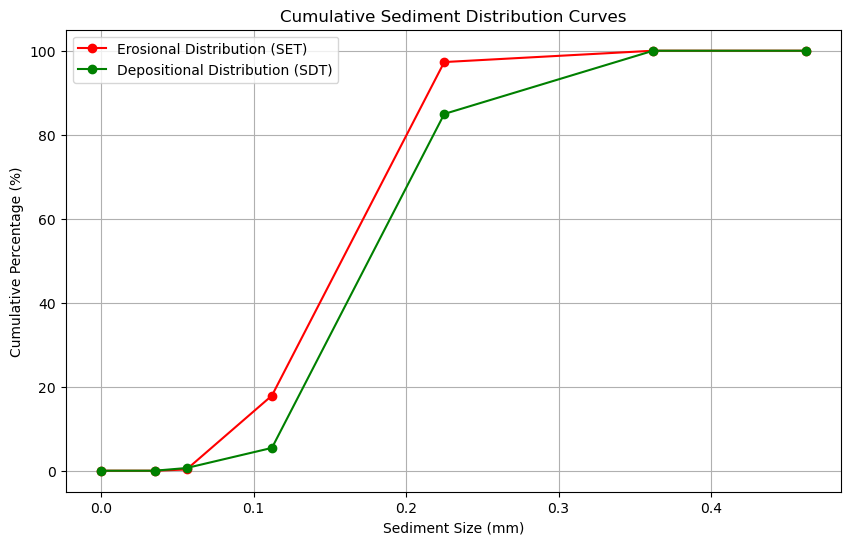

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# This code assumes that the DataFrame FSD has been created and is available.
# The DataFrame should have two rows:
# 'Erosional Distribution (%)' and 'Depositional Distribution (%)'
# and columns named after the sediment sizes (e.g., '0.460 mm').

# Step 1: Extract the data and sort it by sediment size
# The column names contain the sediment sizes, so we need to extract them first
# We create a list of tuples with (float_value, original_column_name)
col_data = [(float(col.split(' ')[0]), col) for col in FSD.columns]

# Sort the list based on the numerical value of the sediment size
col_data.sort(key=lambda x: x[0])

# Get the sorted list of sediment sizes and their corresponding original column names
sorted_sediment_sizes_mm = [item[0] for item in col_data]
sorted_column_names = [item[1] for item in col_data]

# Get the percentage data in the correct, sorted order
sorted_erosional_percentages = FSD.loc['Erosional Distribution (%)', sorted_column_names].values
sorted_depositional_percentages = FSD.loc['Depositional Distribution (%)', sorted_column_names].values

# Step 2: Calculate the cumulative curves
# The cumulative sum for each distribution
cumulative_set = np.cumsum(sorted_erosional_percentages)
cumulative_sdt = np.cumsum(sorted_depositional_percentages)

# Add 0.0 to the beginning for plotting from the origin
cumulative_set = np.insert(cumulative_set, 0, 0.0)
cumulative_sdt = np.insert(cumulative_sdt, 0, 0.0)
# Add a starting point of 0 to the sediment sizes for a better plot
sorted_ss_plot = np.insert(sorted_sediment_sizes_mm, 0, 0.0)

# Step 3: Calculate D16 and D84 for both curves
# We'll use linear interpolation to find the sediment size at 16% and 84%
# For erosional curve
f_erosional = interp1d(cumulative_set, sorted_ss_plot, kind='linear', fill_value='extrapolate')
D16E = f_erosional(16.0)
D84E = f_erosional(84.0)

# For depositional curve
f_depositional = interp1d(cumulative_sdt, sorted_ss_plot, kind='linear', fill_value='extrapolate')
D16D = f_depositional(16.0)
D84D = f_depositional(84.0)

# Store the results in new variables as requested
D16E_val = D16E.item() if isinstance(D16E, np.ndarray) else D16E
D84E_val = D84E.item() if isinstance(D84E, np.ndarray) else D84E
D16D_val = D16D.item() if isinstance(D16D, np.ndarray) else D16D
D84D_val = D84D.item() if isinstance(D84D, np.ndarray) else D84D

print("\n--- Calculated D16 and D84 Values ---")
print(f"Erosional D16: {D16E_val:.3f} mm")
print(f"Erosional D84: {D84E_val:.3f} mm")
print(f"Depositional D16: {D16D_val:.3f} mm")
print(f"Depositional D84: {D84D_val:.3f} mm")

# Step 4: Plot the two cumulative curves on one figure
plt.figure(figsize=(10, 6))
plt.plot(sorted_ss_plot, cumulative_set, marker='o', linestyle='-', color='r', label='Erosional Distribution (SET)')
plt.plot(sorted_ss_plot, cumulative_sdt, marker='o', linestyle='-', color='g', label='Depositional Distribution (SDT)')

# Add title and labels
plt.title('Cumulative Sediment Distribution Curves')
plt.xlabel('Sediment Size (mm)')
plt.ylabel('Cumulative Percentage (%)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

# The variables D16E_val, D84E_val, D16D_val, and D84D_val are now stored
# and available for use in future code cells.


In [71]:
import numpy as np

# This code assumes the following variables are available from previous cells:
# D16E_val (Erosional D16)
# D84E_val (Erosional D84)
# D16D_val (Depositional D16)
# D84D_val (Depositional D84)
# FSD (DataFrame with erosional and depositional distributions)

# =========================================================================
# 1. Calculate the mean sediment size for the EROSIONAL zone
# =========================================================================

# The formula for geometric mean is the square root of (D16 * D84)
# We use the D16E_val and D84E_val variables
MeanE = np.sqrt(D16E_val * D84E_val)

# =========================================================================
# 2. Calculate the mean sediment size for the DEPOSITIONAL zone
# =========================================================================

# The formula for geometric mean is the square root of (D16 * D84)
# We use the D16D_val and D84D_val variables
MeanD = np.sqrt(D16D_val * D84D_val)

# =========================================================================
# 3. Calculate the Coefficient of Incompatibility of Grain Size (CIGG)
# =========================================================================

# The formula for CIGG is the ratio of Mean Erosion to Mean Deposition
if MeanD != 0:
    CIGG = MeanE / MeanD
else:
    CIGG = np.nan # Avoid division by zero
    print("Warning: Mean Depositional Sediment Size is zero, CIGG cannot be calculated.")

# =========================================================================
# 4. Calculate the Coefficient of Incompatibility of Percentage Modifiers (CIPM)
# =========================================================================

print("\n--- Calculating Coefficient of Incompatibility of Percentage Modifiers (CIPM) ---")

# Extract the percentages for both distributions
erosional_percentages = FSD.loc['Erosional Distribution (%)'].values
depositional_percentages = FSD.loc['Depositional Distribution (%)'].values

# Check if the number of percentages matches
if len(erosional_percentages) != len(depositional_percentages):
    print("Error: The number of percentages for erosional and depositional data do not match. Cannot calculate CIPM.")
    CIPM = np.nan
else:
    # Create a list to store the lower percentage for each sediment size
    lower_percentages = []
    
    # Iterate through the percentages and find the lower value for each size
    for i in range(len(erosional_percentages)):
        lower_percentages.append(min(erosional_percentages[i], depositional_percentages[i]))

    # Sum all the lower percentages
    sum_of_lower_percentages = sum(lower_percentages)
    
    # Calculate the CIPM index
    CIPM = sum_of_lower_percentages / 100

# =========================================================================
# 5. Print all the results
# =========================================================================

print("\n--- Calculated Mean Sediment Sizes ---")
print(f"Mean Erosional Sediment Size (MeanE): {MeanE:.3f} mm")
print(f"Mean Depositional Sediment Size (MeanD): {MeanD:.3f} mm")

print("\n--- Calculated CIGG Index ---")
print(f"Coefficient of Incompatibility of Grain Size (CIGG): {CIGG:.3f}")

print("\n--- Calculated CIPM Index ---")
print(f"Sum of Lower Percentages: {sum_of_lower_percentages:.3f}")
print(f"Coefficient of Incompatibility of Percentage Modifiers (CIPM): {CIPM:.3f}")

# The variables MeanE, MeanD, CIGG, and CIPM are now stored and available for future use.



--- Calculating Coefficient of Incompatibility of Percentage Modifiers (CIPM) ---

--- Calculated Mean Sediment Sizes ---
Mean Erosional Sediment Size (MeanE): 0.148 mm
Mean Depositional Sediment Size (MeanD): 0.169 mm

--- Calculated CIGG Index ---
Coefficient of Incompatibility of Grain Size (CIGG): 0.877

--- Calculated CIPM Index ---
Sum of Lower Percentages: 87.198
Coefficient of Incompatibility of Percentage Modifiers (CIPM): 0.872


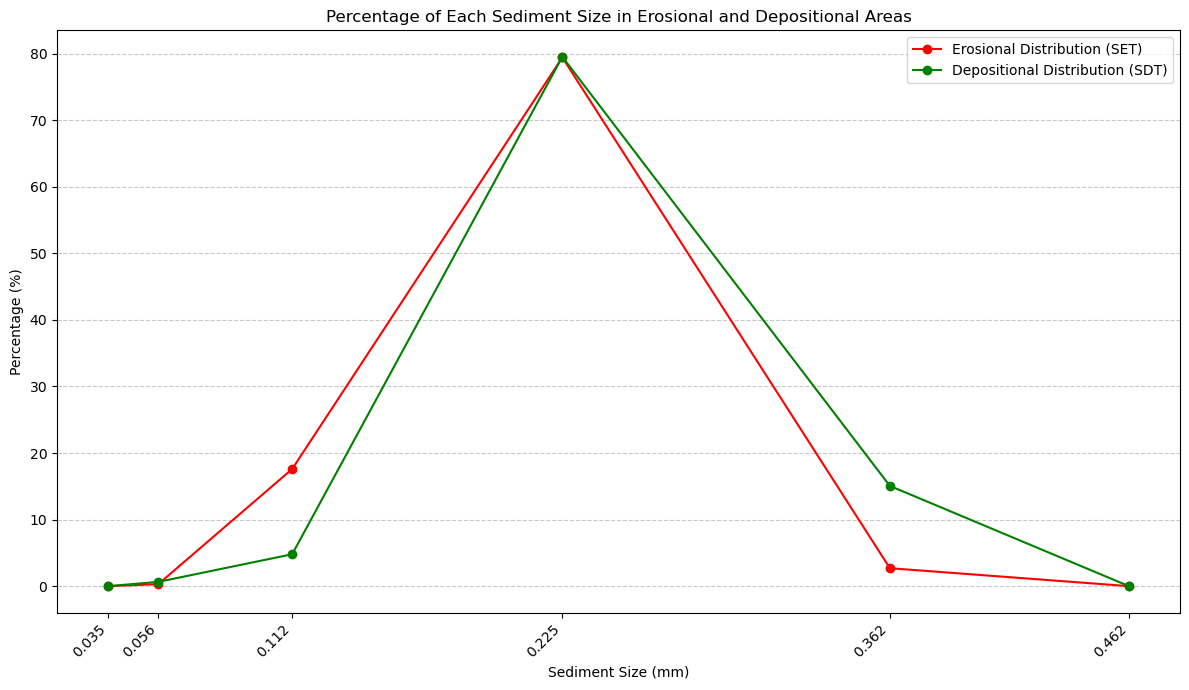

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This code assumes that the DataFrame FSD has been created and is available.
# The DataFrame should have two rows:
# 'Erosional Distribution (%)' and 'Depositional Distribution (%)'
# and columns named after the sediment sizes (e.g., '0.460 mm').

# Step 1: Extract the data and sort it by sediment size
# The column names contain the sediment sizes, so we need to extract them first
# We create a list of tuples with (float_value, original_column_name)
col_data = [(float(col.split(' ')[0]), col) for col in FSD.columns]

# Sort the list based on the numerical value of the sediment size
col_data.sort(key=lambda x: x[0])

# Get the sorted list of sediment sizes and their corresponding original column names
sorted_sediment_sizes_mm = [item[0] for item in col_data]
sorted_column_names = [item[1] for item in col_data]

# Get the percentage data in the correct, sorted order
sorted_erosional_percentages = FSD.loc['Erosional Distribution (%)', sorted_column_names].values
sorted_depositional_percentages = FSD.loc['Depositional Distribution (%)', sorted_column_names].values

# Step 2: Set up the figure and plot the line graph
plt.figure(figsize=(12, 7))

# Plot the erosional percentages as a line graph
plt.plot(sorted_sediment_sizes_mm, sorted_erosional_percentages, marker='o', linestyle='-', color='r', label='Erosional Distribution (SET)')

# Plot the depositional percentages as a line graph
plt.plot(sorted_sediment_sizes_mm, sorted_depositional_percentages, marker='o', linestyle='-', color='g', label='Depositional Distribution (SDT)')

# Step 3: Add title, labels, and other plot enhancements
plt.title('Percentage of Each Sediment Size in Erosional and Depositional Areas')
plt.xlabel('Sediment Size (mm)')
plt.ylabel('Percentage (%)')
plt.xticks(sorted_sediment_sizes_mm, [f'{s:.3f}' for s in sorted_sediment_sizes_mm], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()


In [73]:
import pandas as pd
import numpy as np

# The FSD DataFrame is assumed to be defined from previous steps.

# Step 1: Extract the erosional and depositional data
# The `Fe` is the row for 'Erosional Distribution (%)'
Fe = FSD.loc['Erosional Distribution (%)']

# The `Sf` is the cumulative sum of 'Depositional Distribution (%)' from right to left
depositional_dist = FSD.loc['Depositional Distribution (%)']
Sf = np.cumsum(depositional_dist.values[::-1])[::-1]

# Step 2: Extract and clean the sediment sizes from the FSD DataFrame columns
SS_clean = FSD.columns.str.replace(' mm', '').astype(float)

# Step 3: Create the final DataFrames to display the results
# The data is assigned directly to a new DataFrame with the correct index and column name
Fe_df = pd.DataFrame({'Fraction of Erosion (Fe)': Fe.values}, index=SS_clean)
Sf_df = pd.DataFrame({'Stability Factor (SF)': Sf}, index=SS_clean)

# Step 4: Sort the DataFrames by sediment size (ascending) for better readability
Fe_df = Fe_df.sort_index()
Sf_df = Sf_df.sort_index()

# Step 5: Display the results in the desired format
print("Fraction of Erosion (Fe) for each sediment size:")
print(Fe_df)
print("\nStability Factor (SF) for each sediment size:")
print(Sf_df)

Fraction of Erosion (Fe) for each sediment size:
       Fraction of Erosion (Fe)
0.035                     0.000
0.056                     0.298
0.112                    17.594
0.225                    79.410
0.362                     2.698
0.462                     0.000

Stability Factor (SF) for each sediment size:
       Stability Factor (SF)
0.035                  0.000
0.056                  0.643
0.112                  5.435
0.225                 84.945
0.362                 99.999
0.462                 99.999


In [75]:
import numpy as np

# This code assumes the 'FSD' DataFrame has been created and is available.

# Step 1: Extract Fe and Sf arrays. The FSD DataFrame's columns are already
# in the correct order (coarsest to finest), so the resulting arrays are too.
Fe = np.array(FSD.loc['Erosional Distribution (%)'])
depositional_dist = FSD.loc['Depositional Distribution (%)'].values
Sf = np.cumsum(depositional_dist[::-1])[::-1]

# Step 2: Create the averaged Sf array based on the formula.
# For the first element (coarsest size), SF0 = SF1.
averaged_Sf = np.zeros_like(Sf)
averaged_Sf[0] = Sf[0]
averaged_Sf[1:] = (Sf[1:] + Sf[:-1]) / 2.0

# Step 3: Calculate the CIPP index.
# The summation is performed using a vectorized operation for efficiency.
CIPP = (np.sum(Fe * averaged_Sf) / 100.0) / 100

# Step 4: Display the result and store the variable.
print(f"The calculated CIPP value is: {CIPP:.3f}")

# The CIPP variable is now available for future use.

The calculated CIPP value is: 0.841


Predicted Shoreline Change (Rp): 58.55 m
Predicted Shoreline Change (Rm): 60.72 m
Predicted Shoreline Change (Rg): 61.05 m

--- Generating Bar Graph ---


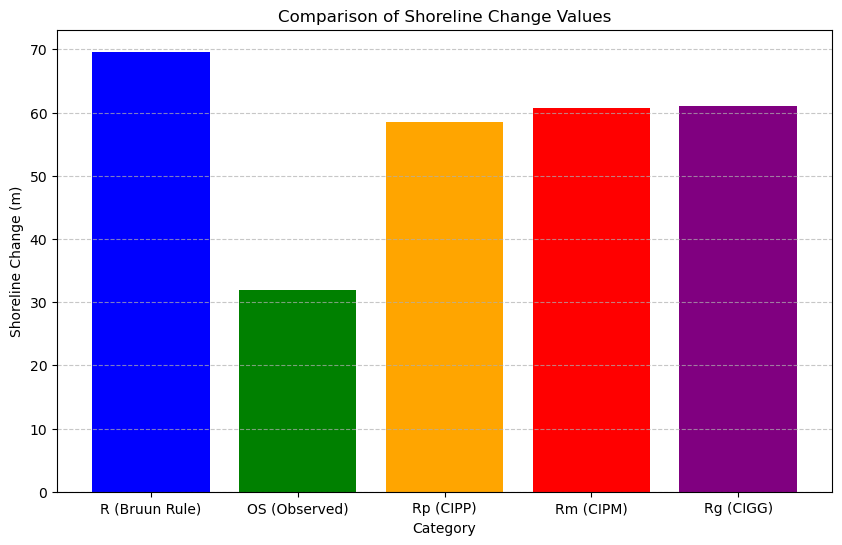

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# This code assumes the following variables are available from previous cells:
# R (Bruun Rule shoreline advancement)
# OS (Observed shoreline change)
# CIPP (CIPP index)
# CIPM (CIPM index)
# CIGG (CIGG index)

# =========================================================================
# 1. Calculate the modified shoreline changes
# =========================================================================

# Calculate Rp (Predicted shoreline change modified by CIPP)
# The P in Rp is subscript
Rp = CIPP * R

# Calculate Rm (Predicted shoreline change modified by CIPM)
# The m in Rm is subscript
Rm = CIPM * R

# Calculate Rg (Predicted shoreline change modified by CIGG)
# The g in Rg is subscript
Rg = CIGG * R

# =========================================================================
# 2. Display the calculated values
# =========================================================================

print(f"Predicted Shoreline Change (Rp): {Rp:.2f} m")
print(f"Predicted Shoreline Change (Rm): {Rm:.2f} m")
print(f"Predicted Shoreline Change (Rg): {Rg:.2f} m")

# =========================================================================
# 3. Plotting the results
# =========================================================================

print("\n--- Generating Bar Graph ---")

# Create a DataFrame for easy plotting
data = {
    'Category': ['R (Bruun Rule)', 'OS (Observed)', 'Rp (CIPP)', 'Rm (CIPM)', 'Rg (CIGG)'],
    'Value': [R, OS, Rp, Rm, Rg]
}
df_plot = pd.DataFrame(data)

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(df_plot['Category'], df_plot['Value'], color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Comparison of Shoreline Change Values')
plt.ylabel('Shoreline Change (m)')
plt.xlabel('Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# The variables Rp, Rm, and Rg are now stored and available for future use.

This station is in the suitable bed slope range (0.01 < BS <= 0.02).
The optimal index is the average of CIPP and CIPM: 0.856

Final optimal shoreline prediction (Ro): 59.63 m


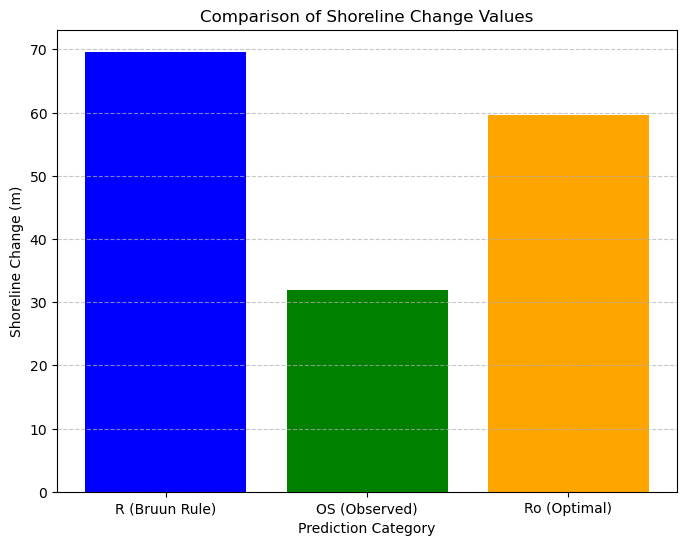

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# This code assumes the following variables are available from previous cells:
# BS (Profile Bed Slope)
# R (Bruun Rule shoreline advancement)
# OS (Observed shoreline change)
# CIPP, CIPM, CIGG (calculated indices)

# Step 1: Check the bed slope (BS)
if BS > 0.02:
    # If BS > 0.02, R is the optimal prediction.
    Ro = R
    optimal_index = None  # No specific index is used, so we set this to None
    print("The profile bed slope (BS) is > 0.02. R is the optimal shoreline prediction.")

elif 0 < BS <= 0.01:
    # This is the "lower bed slope range"
    print("This station is in the lower bed slope range (0 < BS <= 0.01).")
    
    # Check the condition for optimal index
    if CIPP < CIGG and CIGG < CIPM:
        optimal_index = CIGG
        print("CIPP < CIGG < CIPM. The optimal index is CIGG.")
    else:
        optimal_index = min(CIPP, CIGG, CIPM)
        print(f"The optimal index is the minimum of the three: {optimal_index:.3f}")
        
    # Calculate Ro using the selected optimal index
    Ro = optimal_index * R
    
elif 0.01 < BS <= 0.02:
    # This is the "suitable bed slope range"
    print("This station is in the suitable bed slope range (0.01 < BS <= 0.02).")
    
    # Check the condition for optimal index
    if CIPP < CIGG and CIGG < CIPM:
        optimal_index = CIGG
        print("CIPP < CIGG < CIPM. The optimal index is CIGG.")
    else:
        optimal_index = (CIPP + CIPM) / 2
        print(f"The optimal index is the average of CIPP and CIPM: {optimal_index:.3f}")
    
    # Calculate Ro using the selected optimal index
    Ro = optimal_index * R

else:
    # Handle cases where BS is not in the specified ranges.
    Ro = None
    optimal_index = None
    print("The profile bed slope is not within the defined calculation ranges.")

# Step 2: Plot the results if Ro was calculated
if Ro is not None:
    print(f"\nFinal optimal shoreline prediction (Ro): {Ro:.2f} m")

    # Create a DataFrame for easy plotting
    data_to_plot = {
        'Category': ['R (Bruun Rule)', 'OS (Observed)', 'Ro (Optimal)'],
        'Value': [R, OS, Ro]
    }
    df_plot = pd.DataFrame(data_to_plot)

    # Create the bar graph
    plt.figure(figsize=(8, 6))
    plt.bar(df_plot['Category'], df_plot['Value'], color=['blue', 'green', 'orange'])
    plt.title('Comparison of Shoreline Change Values')
    plt.ylabel('Shoreline Change (m)')
    plt.xlabel('Prediction Category')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# The variables Ro and optimal_index are now stored for future use.